### Project Outline

* Read data and create subset for ones that don't have VIAF ID. 
    * We might work with the entire dataset though, because more data might make clustering names easier.
* Create 3 new columns: `parsedName`, `_personID`, `regularizedName`
    * The leading underscore indicates `personId` is a temporary column. The ID can just be a sequential integer as long as it's unique - it doesn't need to be a true hash.
    * Whether we can reliably create a `regularizedName` - i.e. a modern regular version that should replace all variations in the metadata remains to be seen. It might not be possible without a lot of human intervention. 
* We need the following functions:
    * `name_preprocess()`: Returns a cleaned up version of the name string or `None` if it doesn't look like a name.
    * `substitution_cost()`: Needed for `weighted_levenshteain()`
    * `substitution_cost_dict_generate()`: generate a cost dict for `weighted_levenshtein()`
    * `weighted_levenshtein()`
    * `name_pair()`: take a pair of preprocessed names and return a `true` if they are a close enough match that we should compute `weighted_levenshtein()` or `false` if we should ignore them. 
    * `ner_pubStmt()`: Takes the `pubStmt()` field and runs NER with `Spacy` on it.
* Procedure:
    * For each row, run `name_preprocess()`. 
        * If we get a name back, we store it in `parsedName`
    * After we are done with the entire DataFrame, take the subset that has `parsedName` set.
        * The other rows get written out to a CSV (without the 3 new columns -- these need to be run through NER and/or checked by hand)
    * In the new subset DataFrame, we generate combinations of pd.Dataframe `index` ids to generate all possible name pairs. Then run them through `name_pair()`.
    * If they pass, we run them through `weighted_levenshtein()` and store the result in a `networkx` graph where the nodes are pd.Dataframe `id` and the edges are 1/weigthed_levenshtein() \[i.e. the more similar the nodes, the higher the weight\]. If the `weighted_levenshtein()` score is above a certain threshold, we don't add it to the graph. 
    * When we are done, we break down the graph into discrete subgraphs using [this approach](https://stackoverflow.com/questions/61536745/how-to-separate-an-unconnected-networkx-graph-into-multiple-mutually-disjoint-gr). Each subgraph will be one name in all its variant forms. This performs the clustering for us. 
    * We sort these graphs by number of nodes and assign each of them a unique ID starting at 1 and then write everythin out to a CSV.

In [36]:
%load_ext line_profiler

# Set up all imports and logging
import itertools, json, logging, re, string, sys
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from strsimpy.weighted_levenshtein import WeightedLevenshtein

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

sh = logging.StreamHandler(sys.stderr)
sh.setLevel(logging.INFO)
fmt = '%(asctime)s %(message)s'
dfmt = '%y-%m-%d  %H:%M:%S'
logging.basicConfig(handlers=(sh,), format=fmt, datefmt=dfmt, level=logging.INFO)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


##### All adjustable parameters are set here

In [74]:
printers_data_file = 'data/printers_etc.csv'
name_abbreviations_file ='./data/name_abbreviations.json'

# We'll output bad data to these files
printers_data_file_date_notparsed_doubleyears = 'data/printers_etc_date_notparsed_doubleyears.csv'
printers_data_file_date_notparsed = 'data/printers_etc_date_notparsed.csv'
printers_data_file_pubstmt_notparsed = 'data/printers_etc_pubstmt_notparsed.csv'

n_test = 0    # Subset of data for tests. Set to 0 or more than the total datasize to use everything.
records_with_viaf = False    # Whether we eliminate items that already have a resolved VIAF ID

# Change these values to zoom in on shorter yearspans in the visualization
start_year = 1400
end_year = 1700
records_within_datespan = True # If this is set, only the above datespan is kept

# This needs to have both (c1, c2) and (c2, c1) pairs only if the weights are different. 
# Otherwise (c2, c1) etc is generated automatically below.
substitution_cost_dict = {('i', 'j'): 0.3,
                          ('u', 'v'): 0.3,
                          ('y', 'i'): 0.3,
                          ('e', 'y'):.7}

##### Read external files and visualize raw data

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (7,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
23-03-02  04:22:43 Writing records with two date strings to data/printers_etc_date_notparsed_doubleyears.csv
23-03-02  04:22:43 Writing records with bad date fields to data/printers_etc_date_notparsed.csv


Total Number of texts:         78,112
Texts with VIAF IDs:           15,927
Texts without VIAF IDs:        62,185
Texts with bad dates (ignored): 2,041


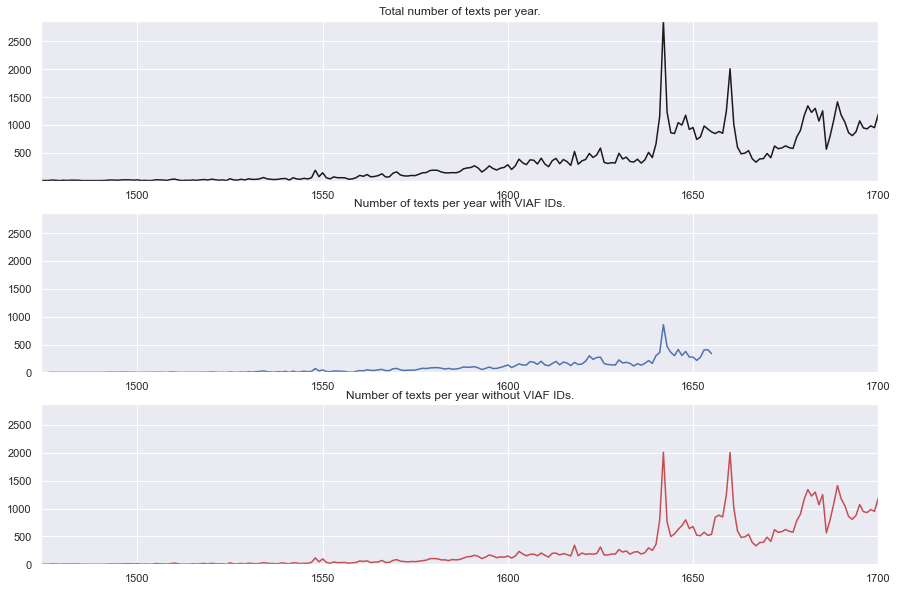

In [75]:
# The name abbreviations dictionary can be passed to the name_preprocess function
with open(name_abbreviations_file) as file:
    name_abbreviations = json.load(file)

printers_df = pd.read_csv(printers_data_file)

# Convert to numeric but leave strings and nans untouched
# Extract dates with two years - eg. 1660 1662
printers_df['parsedDate'] = printers_df['parsedDate'].apply(pd.to_numeric, errors='ignore')
printers_df_strings = printers_df[printers_df['parsedDate'].apply(lambda x: isinstance(x, str))]
logging.info(f'Writing records with two date strings to {printers_data_file_date_notparsed_doubleyears}')
printers_df_strings.to_csv(printers_data_file_date_notparsed_doubleyears)

# Extract all rows with badly parsed dates (including above rows)
printers_df['parsedDate'] = printers_df['parsedDate'].apply(pd.to_numeric, errors='coerce')
filter_baddates = printers_df['parsedDate'].isna()
printers_df_baddates = printers_df[filter_baddates]
logging.info(f'Writing records with bad date fields to {printers_data_file_date_notparsed}')
printers_df_baddates.to_csv(printers_data_file_date_notparsed)

# Retain rows with well formed dates
printers_df = printers_df[~filter_baddates]

viaf_exists = printers_df[~printers_df['viafId'].isna()]
viaf_needed = printers_df[printers_df['viafId'].isna()]

total_counts = printers_df.groupby(['parsedDate'])['parsedDate'].count()
viaf_exists_counts = viaf_exists.groupby(['parsedDate'])['parsedDate'].count()
viaf_needed_counts = viaf_needed.groupby(['parsedDate'])['parsedDate'].count()

# Set up the plot
sns.set_theme(style="darkgrid")
fig = plt.figure(figsize=(15,10))
grid = plt.GridSpec(3,1)
axes = [fig.add_subplot(grid[0, 0]), fig.add_subplot(grid[1, 0]), fig.add_subplot(grid[2, 0])]

sns.lineplot(data=total_counts, x=total_counts.index, y=total_counts.values, color='k', ax=axes[0])
sns.lineplot(data=viaf_exists_counts, x=viaf_exists_counts.index, y=viaf_exists_counts.values, color='b', ax=axes[1])
sns.lineplot(data=viaf_needed_counts, x=viaf_needed_counts.index, y=viaf_needed_counts.values, color='r', ax=axes[2])

start_year = start_year if int(total_counts.index[0]) < start_year else int(total_counts.index[0])
end_year = end_year if int(total_counts.index[-1]) > end_year else int(total_counts.index[-1])

axes[0].set(xlim=(start_year, end_year), ylim=(1, max(total_counts[start_year:end_year].values+1)), xlabel=None, title='Total number of texts per year.')
axes[1].set(xlim=(start_year, end_year), ylim=(0, max(total_counts[start_year:end_year].values)+1), xlabel=None, title='Number of texts per year with VIAF IDs.')
axes[2].set(xlim=(start_year, end_year), ylim=(0, max(total_counts[start_year:end_year].values)+1), xlabel=None, title='Number of texts per year without VIAF IDs.')
print('Total Number of texts:         {:,}\nTexts with VIAF IDs:           {:,}\nTexts without VIAF IDs:        {:,}\nTexts with bad dates (ignored): {:,}'\
          .format(len(printers_df), len(viaf_exists), len(viaf_needed), len(printers_df_baddates)))

In [76]:
# slice data to produce the final dataframe we'll work on
if records_with_viaf:
    df = printers_df
    logging.info('Including records with assigned VIAF IDs')
else:
    df = viaf_needed
    logging.info('Excluding records with assigned VIAF IDs')

if records_within_datespan:
    df = df[(df['parsedDate']>=start_year) & (df['parsedDate']<=end_year)]
    logging.info(f'Keeping records within {start_year} and {end_year}')
    
if n_test==0:
    df = df
    logging.info(f'Keeping all {len(df)} records')
else:
    df = df[:n_test]
    logging.info(f'Keeping the first {len(df)} records')

23-03-02  04:22:44 Excluding records with assigned VIAF IDs
23-03-02  04:22:44 Keeping records within 1474 and 1700
23-03-02  04:22:44 Keeping all 62150 records


In [77]:
# Functions

def name_preprocess(full_name, lower_case=False, title_case=True, \
                    name_abbreviations=name_abbreviations, \
                    max_length=30, min_tokens=2, max_tokens=4):
    """
    Returns a cleaned up version of the name string or None if it doesn't look like a name.
    
    We remove any preceding 'me', clean up punctuation, extra spaces. Throw out 
    names that are too long or have too few or too many tokens. Substitute vv -> w.
    Also expand name abbreviations. Lower and Title case options available. Titlecase
    takes precedence.
    """
    full_name = re.sub(f'^me\s*|[{string.punctuation}]|\d*', '', full_name)
    # Collapse vv to w
    full_name = re.sub('vv', 'w', full_name)
    full_name = re.sub('VV', 'W', full_name)

    #ignore names that are too long
    if len(full_name) > max_length:
        logging.info(f'Too long: Ignoring: {full_name}')
        return None
    #find all strings separated by whitespace
    words = re.findall(r'\b\w+\b', full_name)
    # check if the number of words is at least 2 or over 4
    if len(words) < min_tokens:
        logging.info(f'Too few tokens: Ignoring: {full_name}')
        return None
    if len(words) > max_tokens:
        logging.info(f'Too many tokens: Ignoring: {full_name}')
        return None
    # return the first word and remaining string as a tuple
    first_name = words[0]
    if first_name in name_abbreviations:
        first_name = name_abbreviations[first_name]
    last_name = ' '.join(words[1:])
    
    if lower_case:
        first_name = first_name.lower()
        last_name = last_name.lower()
    
    if title_case:
        first_name = first_name.title()
        last_name = last_name.title()

    return (first_name, last_name)

def substitution_cost_dict_generate(substitution_cost_dict, swapcase_weight=0.2):
    """
    Generate reverse pairs for the cost dictionary. I.e. is ('u', 'v') is supplied,
    generate ('v', 'u'). ('u', 'V') and ('U', 'v') are also generated. Other letters 
    get the swapcase weight. So the cost of 'A'->'a' is swapcase_weight. This can be 
    set to zero, if you don't care about swapping cases.
    """
    reversed_substitution_cost_dict = {}

    for (c1, c2), w in substitution_cost_dict.items():
        # (i, j) -> (j, i)
        if (c2, c1) not in substitution_cost_dict:
            reversed_substitution_cost_dict[(c2, c1)] = w
        # (i, j) -> (i, J) and (I, j)
        if (c1.swapcase(), c2) not in substitution_cost_dict:
            reversed_substitution_cost_dict[(c1.swapcase(), c2)] = w
        if (c1, c2.swapcase()) not in substitution_cost_dict:
            reversed_substitution_cost_dict[(c1, c2.swapcase())] = w
        # (a, A), (A, a) etc
        for l in string.ascii_letters:
            if (l, l.swapcase()) not in substitution_cost_dict:
                reversed_substitution_cost_dict[(l, l.swapcase())] = swapcase_weight

    substitution_cost_dict = {**substitution_cost_dict, **reversed_substitution_cost_dict}

    return substitution_cost_dict

def substitution_cost(x, y, substitution_cost_dict=substitution_cost_dict):
    """
    Takes a pair of letters and returns a substitution cost for them
    """
    sc = substitution_cost_dict[(x,y)] if (x, y) in substitution_cost_dict else 1.0
    return sc

def name_pair(n1, n2, letter_similarity_threshold=.5):
    """
    This is a prescreening function to judge if a pair of names is viable for a match
    with weighted levenshtein. We can set up various criteria for a possible match.
    
    If names have same or similar initials. 
    Not implemented yet: If they share a substantial portion of their letters.
    """
    f1, l1 = n1
    f2, l2 = n2
    
    # Do they have same or similar initials
    if (((f1[0]==f2[0]) or (substitution_cost(f1[0], f2[0])<letter_similarity_threshold)) and \
                      ((l1[0]==l2[0]) or (substitution_cost(l1[0], l2[0])<letter_similarity_threshold))):
        return True
    return False

def name_pair_combinations(df, dateRange=40):
    """
    Returns vialble name pairs as a list of indices. Note that each name will show
    up at least once as it is similar to itself. So unique names are accounted for.
    """
    filter = []
    for i, ni1 in enumerate(df.itertuples()):
        if i%1000 == 0:
            logging.info(f'Name pairs parsed: {i}')
        for ni2 in df[i:].itertuples():
            if abs(ni1.parsedDate - ni2.parsedDate) <= dateRange:
                name1 = ni1.namePreprocessed
                name2 = ni2.namePreprocessed
                index1 = ni1.Index
                index2 = ni2.Index
                if name_pair(name1, name2):
                    filter.append((index1, index2))
    return filter

def name_pair_combinations_(df):
    df_trimmed = df.drop(['tcpid','role','role_edited','name','source','title','author','date', 'parsedDate','place','pubStmt','nameResolved','viafId'], axis=1)
    df_trimmed['indexCopy'] = df_trimmed.index
    dtj = df_trimmed.join(df_trimmed, how='cross', lsuffix='_1', rsuffix='_2')
    return dtj.apply(lambda x: name_pair(x['namePreprocessed_1'], x['namePreprocessed_2']), axis=1)

def weighted_levenshtein_compute(n1, n2, weighted_levenshtein_function, initial_match_weight=.2):
    f1, l1 = n1
    f2, l2 = n2

    if (f1 == f2) and (l1 == l2):
        d1 = 0
        d2 = 0
    elif (len(f1) == 1 or len(f2) == 1) and (f1[0] == f2[0]):
        d1 = initial_match_weight
        d2 = weighted_levenshtein(l1, l2)
    else:
        d1 = weighted_levenshtein(f1, f2)
        d2 = weighted_levenshtein(l1, l2)
    return (d1+d2)
    
# We'll call the above function to expand our cost dictionary
substitution_cost_dict = substitution_cost_dict_generate(substitution_cost_dict)

# Initialize the WL function with custom weights
weighted_levenshtein = WeightedLevenshtein(substitution_cost_fn=substitution_cost)

In [78]:
# Preprocess all names and create new column for it
df['namePreprocessed'] = df['name'].map(name_preprocess)

# Separate rows that don't look like names. We'll clean these later
df_unresolved_name = df[df['namePreprocessed'].isnull()]
logging.info(f'Writing {len(df_unresolved_name)} unresolved names to {printers_data_file_pubstmt_notparsed}')
df_unresolved_name.to_csv(printers_data_file_pubstmt_notparsed)

df = df[~df['namePreprocessed'].isnull()]
logging.info(f'{len(df)} names resolved')

23-03-02  04:22:56 Too long: Ignoring: Caxton William approximately  or 
23-03-02  04:22:56 Too long: Ignoring: Caxton William approximately  or 
23-03-02  04:22:56 Too long: Ignoring: Caxton William approximately  or 
23-03-02  04:22:56 Too long: Ignoring: Caxton William approximately  or 
23-03-02  04:22:56 Too long: Ignoring: Caxton William approximately  or 
23-03-02  04:22:56 Too long: Ignoring: Caxton William approximately  or 
23-03-02  04:22:56 Too long: Ignoring: Caxton William approximately  or 
23-03-02  04:22:56 Too long: Ignoring: Caxton William approximately  or 
23-03-02  04:22:56 Too long: Ignoring: Caxton William approximately  or 
23-03-02  04:22:56 Too long: Ignoring: Caxton William approximately  or 
23-03-02  04:22:56 Too long: Ignoring: Rivers Anthony Woodville Earl of  
23-03-02  04:22:56 Too long: Ignoring: Caxton William approximately  or 
23-03-02  04:22:56 Too long: Ignoring: Caxton William approximately  or 
23-03-02  04:22:56 Too long: Ignoring: Caxton Will

23-03-02  04:22:56 Too long: Ignoring: Stafford Henry Stafford Baron  
23-03-02  04:22:56 Too few tokens: Ignoring: impress
23-03-02  04:22:56 Too long: Ignoring: Nicolaum Bamburgensem ie Dirik van der Straten
23-03-02  04:22:56 Too many tokens: Ignoring: Elizabeth Queen of England I  
23-03-02  04:22:56 Too few tokens: Ignoring: 
23-03-02  04:22:56 Too long: Ignoring: Byllinges gate In the yeare of oure Lorde MDXLVIII And they
23-03-02  04:22:56 Too long: Ignoring: Berners John Bourchier Lord  or 
23-03-02  04:22:56 Too long: Ignoring: Willyam Seres Dwellynge wythout Temple barre
23-03-02  04:22:56 Too many tokens: Ignoring: Mary Queen of England I  
23-03-02  04:22:56 Too few tokens: Ignoring: Dwellyng
23-03-02  04:22:56 Too few tokens: Ignoring: 
23-03-02  04:22:56 Too long: Ignoring: Willyam Seres Dwellyng wythout Aldersgate
23-03-02  04:22:56 Too few tokens: Ignoring: Septennium
23-03-02  04:22:56 Too few tokens: Ignoring: Ludgate
23-03-02  04:22:56 Too many tokens: Ignoring: the 

23-03-02  04:22:56 Too long: Ignoring: Iohn Lyon ie Greenstreet House Press
23-03-02  04:22:56 Too long: Ignoring: the Queenes most excellent Maiestie
23-03-02  04:22:56 Too few tokens: Ignoring: aucthoritie
23-03-02  04:22:56 Too long: Ignoring: Henricus Middletonus impensis Thomæ Man
23-03-02  04:22:56 Too long: Ignoring: Iohn Lion ie Greenstreet House Press
23-03-02  04:22:56 Too long: Ignoring: the Queenes most excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Queenes most excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Queenes most excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Queenes most excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Queenes most excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Queenes moat excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: Edwarde Aggas and Thomas Chare sic
23-03-02  04:22:56 Too long: Ignoring: J Charlewood and Richard Ihones
23-03-02  04:22:56 Too many tokens: Ignori

23-03-02  04:22:56 Too long: Ignoring: S Milanges ie T Orwin ordinarie
23-03-02  04:22:56 Too long: Ignoring: Martin Iunior without any priuiledge of the Catercaps
23-03-02  04:22:56 Too many tokens: Ignoring: Iohn Astile ie T Orwin
23-03-02  04:22:56 Too few tokens: Ignoring: amp
23-03-02  04:22:56 Too long: Ignoring: Signior Somebody ie Eliots Court Press
23-03-02  04:22:56 Too long: Ignoring: the Queenes most excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the deputies of Christopher Barker
23-03-02  04:22:56 Too long: Ignoring: the deputies of Christopher Barker printer the Queenes most excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Queenes most excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Deputies of Christopher Barker
23-03-02  04:22:56 Too long: Ignoring: the Queenes most excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the deputies of Christopher Barker
23-03-02  04:22:56 Too long: Ignoring: the Queenes most excellent Maiestie


23-03-02  04:22:56 Too long: Ignoring: the deputies of Christopher Barker
23-03-02  04:22:56 Too long: Ignoring: the Queenes most excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the deputies of Christopher Barker
23-03-02  04:22:56 Too long: Ignoring: the Queenes most excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the deputies of Christopher Barker
23-03-02  04:22:56 Too long: Ignoring: the Queenes most excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the deputies of Christopher Barker
23-03-02  04:22:56 Too long: Ignoring: the Queenes most excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Deputies of Christopher Barker
23-03-02  04:22:56 Too long: Ignoring: the Queenes most excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the deputies of Christopher Barker
23-03-02  04:22:56 Too long: Ignoring: the Queenes most excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the deputies of Christopher Barker
23-03-02  04:22:56 Too long: Ign

23-03-02  04:22:56 Too long: Ignoring: the Queenes most excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Deputies of Christopher Barker
23-03-02  04:22:56 Too long: Ignoring: the deputies of Christopher Barker
23-03-02  04:22:56 Too many tokens: Ignoring: the deputies of C Barker
23-03-02  04:22:56 Too many tokens: Ignoring: ye Honorable Cittie of London
23-03-02  04:22:56 Too few tokens: Ignoring: amp
23-03-02  04:22:56 Too long: Ignoring: Edm Bollifant impensis George Bishop
23-03-02  04:22:56 Too long: Ignoring: Robert Waldegraue according to the copie printed
23-03-02  04:22:56 Too long: Ignoring: Vaughan Edward preacher at St Mary Woolnoth
23-03-02  04:22:56 Too few tokens: Ignoring: IR
23-03-02  04:22:56 Too many tokens: Ignoring: the honorable citie of London
23-03-02  04:22:56 Too long: Ignoring: Robinson Richard citizen of London
23-03-02  04:22:56 Too few tokens: Ignoring: Bonham
23-03-02  04:22:56 Too long: Ignoring: the deputies of Christopher Barker
23-03-02  

23-03-02  04:22:56 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Kings most excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Kings most excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Kings most excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Kings mo

23-03-02  04:22:56 Too few tokens: Ignoring: AJ
23-03-02  04:22:56 Too long: Ignoring: the Vniuersitie of Cambridge  And
23-03-02  04:22:56 Too long: Ignoring: the Kings most excellent Maiestie
23-03-02  04:22:56 Too few tokens: Ignoring: sic
23-03-02  04:22:56 Too few tokens: Ignoring: Arthur
23-03-02  04:22:56 Too few tokens: Ignoring: Iohnson
23-03-02  04:22:56 Too few tokens: Ignoring: EE
23-03-02  04:22:56 Too long: Ignoring: the Vniuersitie of Cambridge And
23-03-02  04:22:56 Too few tokens: Ignoring: TD
23-03-02  04:22:56 Too few tokens: Ignoring: 
23-03-02  04:22:56 Too many tokens: Ignoring: L Greene of Cambridge  And
23-03-02  04:22:56 Too long: Ignoring: the Vniversitie of Cambridge  And
23-03-02  04:22:56 Too long: Ignoring: the Kings most excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Kings most excellent Maiestie
23-03-02  04:22:56 Too few tokens: Ignoring: WI
23-03-02  04:22:56 Too long: Ignoring: Richard Field impensis Georg Bishop
23-03-02  04:22:56 Too 

23-03-02  04:22:56 Too long: Ignoring: the Vniuersitie of Cambridge  And
23-03-02  04:22:56 Too long: Ignoring: Hudson Thomas active th centuryth century
23-03-02  04:22:56 Too long: Ignoring: typographica Ioannis Laquehay via Iudæ
23-03-02  04:22:56 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:56 Too few tokens: Ignoring: TC
23-03-02  04:22:56 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Kings most excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:56 Too few tokens: Ignoring: WW
23-03-02  04:22:56 Too many tokens: Ignoring: the Honorable Citty of London
23-03-02  04:22:56 Too long: Ignoring: the Kings most excellent Maiestie
23-03-02  04

23-03-02  04:22:56 Too long: Ignoring: Comp Holland ouer against thexchange
23-03-02  04:22:56 Too few tokens: Ignoring: IB
23-03-02  04:22:56 Too long: Ignoring: the Kings most excellent Maiestie
23-03-02  04:22:56 Too few tokens: Ignoring: TS
23-03-02  04:22:56 Too long: Ignoring: the Kings most excellent Maiestie
23-03-02  04:22:56 Too long: Ignoring: Thomas Kellam ie the Birchley Hall press
23-03-02  04:22:56 Too long: Ignoring: Nortoniana apud Ioannem Billium
23-03-02  04:22:57 Too long: Ignoring: the Kings most excellent Majestie
23-03-02  04:22:57 Too few tokens: Ignoring: EG
23-03-02  04:22:57 Too long: Ignoring: the Queenes Maiestie ie B Norton
23-03-02  04:22:57 Too many tokens: Ignoring: Richard Iugge ie B Norton
23-03-02  04:22:57 Too many tokens: Ignoring: Iohn Cawoodde ie B Norton
23-03-02  04:22:57 Too long: Ignoring: the Quenes Maiestie ie B Norton
23-03-02  04:22:57 Too long: Ignoring: the Queenes Maiesty ie B Norton
23-03-02  04:22:57 Too long: Ignoring: the Queenes M

23-03-02  04:22:57 Too long: Ignoring: Thomas Snodham ex typographia Societatis Stationariorum
23-03-02  04:22:57 Too few tokens: Ignoring: IT
23-03-02  04:22:57 Too long: Ignoring: William Stansby or William Jones
23-03-02  04:22:57 Too few tokens: Ignoring: HG
23-03-02  04:22:57 Too many tokens: Ignoring: Bernard Alsop and are to be
23-03-02  04:22:57 Too few tokens: Ignoring: WI
23-03-02  04:22:57 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:57 Too few tokens: Ignoring: WI
23-03-02  04:22:57 Too few tokens: Ignoring: GP
23-03-02  04:22:57 Too long: Ignoring: Printers to the Kings most Excellent Maiestie
23-03-02  04:22:57 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:57 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:57 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:57 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:57 Too long: Ignoring: the Kings most Excellent Maies

23-03-02  04:22:57 Too long: Ignoring: the Kings most excellent Maiestie
23-03-02  04:22:57 Too long: Ignoring: the Kings most excellent Maiestie
23-03-02  04:22:57 Too long: Ignoring: the Kings most excellent Maiestie
23-03-02  04:22:57 Too long: Ignoring: the Kings most excellent Maiestie
23-03-02  04:22:57 Too few tokens: Ignoring:  printed
23-03-02  04:22:57 Too many tokens: Ignoring: the Honourable Citie of London
23-03-02  04:22:57 Too few tokens: Ignoring: WI
23-03-02  04:22:57 Too few tokens: Ignoring: FK
23-03-02  04:22:57 Too few tokens: Ignoring: GP
23-03-02  04:22:57 Too long: Ignoring: the Kings most excellent Maiestie
23-03-02  04:22:57 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:57 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:57 Too long: Ignoring: the Kings most excellent Maiestie
23-03-02  04:22:57 Too long: Ignoring: the Kings most excellent Maiestie
23-03-02  04:22:57 Too long: Ignoring: the Kings most excellent Maie

23-03-02  04:22:57 Too few tokens: Ignoring: WT
23-03-02  04:22:57 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:57 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:57 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:57 Too long: Ignoring: Printers to the Kings most Excellent Maiestie
23-03-02  04:22:57 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:57 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:57 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:57 Too few tokens: Ignoring: HG
23-03-02  04:22:57 Too few tokens: Ignoring: TS
23-03-02  04:22:57 Too few tokens: Ignoring: HG
23-03-02  04:22:57 Too few tokens: Ignoring: HG
23-03-02  04:22:57 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:57 Too few tokens: Ignoring: IL
23-03-02  04:22:57 Too few tokens: Ignoring: WT
23-03-02  04:22:57 Too long: Ignoring: the Kings most Excellent Maje

23-03-02  04:22:57 Too long: Ignoring: the printers to the Vniversitie of Cambridge
23-03-02  04:22:57 Too many tokens: Ignoring: the successors of Giles Thorp
23-03-02  04:22:57 Too few tokens: Ignoring:  And
23-03-02  04:22:57 Too many tokens: Ignoring: the Heyres of Robert Charteris
23-03-02  04:22:57 Too few tokens: Ignoring: HL
23-03-02  04:22:57 Too many tokens: Ignoring: the heires of Andro Hart
23-03-02  04:22:57 Too many tokens: Ignoring: the heires of Andro Hart
23-03-02  04:22:57 Too long: Ignoring: the Kings most excellent Maiestie
23-03-02  04:22:57 Too long: Ignoring: the Kings most excellent Maiesty
23-03-02  04:22:57 Too few tokens: Ignoring: Thomas
23-03-02  04:22:57 Too long: Ignoring: the printers to the Vniversity of Cambridge
23-03-02  04:22:57 Too long: Ignoring: the printers to the Vniversitie of Cambridge
23-03-02  04:22:57 Too long: Ignoring: Printers to the Kings most Excellent Maiestie
23-03-02  04:22:57 Too long: Ignoring: the Kings most Excellent Maiestie
2

23-03-02  04:22:57 Too few tokens: Ignoring: RY
23-03-02  04:22:57 Too many tokens: Ignoring: the widow of Nicholas Courant
23-03-02  04:22:57 Too few tokens: Ignoring: IB
23-03-02  04:22:57 Too few tokens: Ignoring: IB
23-03-02  04:22:57 Too few tokens: Ignoring: LG
23-03-02  04:22:57 Too long: Ignoring: the Kings most excellent Maiestie and
23-03-02  04:22:57 Too long: Ignoring: the high and mightie Lords the Stats Generall
23-03-02  04:22:57 Too long: Ignoring: the widowe amp heires of the deceased Hillebrand Iacobs van Wouw ordinarie
23-03-02  04:22:57 Too long: Ignoring: William Stansby impensis Roberti Mylbourn
23-03-02  04:22:57 Too long: Ignoring: the successors of Giles Thorp and
23-03-02  04:22:57 Too long: Ignoring: the Partners of the Irish Stocke
23-03-02  04:22:57 Too long: Ignoring: the Partners of the Irish Stocke
23-03-02  04:22:57 Too few tokens: Ignoring: GM
23-03-02  04:22:57 Too few tokens: Ignoring: 
23-03-02  04:22:57 Too long: Ignoring: the Kings most Excellent 

23-03-02  04:22:57 Too long: Ignoring: the Kings most excellent Maiestie and
23-03-02  04:22:57 Too long: Ignoring: the Kings most excellent Maiestie and
23-03-02  04:22:57 Too long: Ignoring: the Kings most excellent Maiestie and
23-03-02  04:22:57 Too long: Ignoring: Robert Barker printer of the Kings most excellent Maiestie and
23-03-02  04:22:57 Too long: Ignoring: the printers to the Vniversitie of Cambridge
23-03-02  04:22:57 Too long: Ignoring: the Kings most excellent Majestie
23-03-02  04:22:57 Too long: Ignoring: the Society of Stationers printed
23-03-02  04:22:57 Too long: Ignoring: John Clarke under S Peters Church
23-03-02  04:22:57 Too many tokens: Ignoring: the widowe of Jhon Mommart
23-03-02  04:22:57 Too many tokens: Ignoring: T H Sir Thomas Hawkins 
23-03-02  04:22:57 Too long: Ignoring: Mayerne Théodore Turquet de Sir  
23-03-02  04:22:57 Too few tokens: Ignoring: IH
23-03-02  04:22:57 Too few tokens: Ignoring: Thomas
23-03-02  04:22:57 Too long: Ignoring: John Buc

23-03-02  04:22:57 Too long: Ignoring: the Kings most Excellent Maiesty and
23-03-02  04:22:57 Too long: Ignoring: the Kings most Excellent Maiestie And
23-03-02  04:22:57 Too many tokens: Ignoring: the Assignes of Iohn Bill
23-03-02  04:22:57 Too long: Ignoring: the Kings most Excellent Maiestie And
23-03-02  04:22:57 Too many tokens: Ignoring: the Assignes of Iohn Bill
23-03-02  04:22:57 Too long: Ignoring: the Kings most Excellent Maiestie And
23-03-02  04:22:57 Too many tokens: Ignoring: the Assignes of Iohn Bill
23-03-02  04:22:57 Too long: Ignoring: the Kings most Excellent Maiestie And
23-03-02  04:22:57 Too many tokens: Ignoring: the Assignes of Iohn Bill
23-03-02  04:22:57 Too long: Ignoring: the Kings most excellent Maiestie And
23-03-02  04:22:57 Too long: Ignoring: the Kings most Excellent Maiestie And
23-03-02  04:22:57 Too many tokens: Ignoring: the Assignes of Iohn Bill
23-03-02  04:22:57 Too few tokens: Ignoring: RB
23-03-02  04:22:57 Too few tokens: Ignoring: RB
23-03-

23-03-02  04:22:57 Too long: Ignoring: the Kings most Excellent Majestie And
23-03-02  04:22:57 Too long: Ignoring: the Kings most excellent Majestie and
23-03-02  04:22:57 Too few tokens: Ignoring: Scotland
23-03-02  04:22:57 Too long: Ignoring: the printers to the Vniversity of Cambridge And
23-03-02  04:22:57 Too long: Ignoring: the Kings most excellent Majestie
23-03-02  04:22:57 Too few tokens: Ignoring: RH
23-03-02  04:22:57 Too few tokens: Ignoring: JS
23-03-02  04:22:57 Too few tokens: Ignoring: MP
23-03-02  04:22:57 Too few tokens: Ignoring: EP
23-03-02  04:22:57 Too long: Ignoring: the Kings most excellent Majestie and
23-03-02  04:22:57 Too long: Ignoring: the Kings most excellent Majestie and
23-03-02  04:22:57 Too long: Ignoring: the Kings most excellent Majestie and
23-03-02  04:22:57 Too long: Ignoring: the Kings most excellent Majestie and
23-03-02  04:22:57 Too long: Ignoring: the Kings most excellent Majesty and
23-03-02  04:22:57 Too long: Ignoring: the Kings most ex

23-03-02  04:22:57 Too few tokens: Ignoring: GD
23-03-02  04:22:57 Too few tokens: Ignoring: RO
23-03-02  04:22:57 Too few tokens: Ignoring: MS
23-03-02  04:22:57 Too few tokens: Ignoring: TP
23-03-02  04:22:57 Too few tokens: Ignoring: RB
23-03-02  04:22:57 Too few tokens: Ignoring: AN
23-03-02  04:22:57 Too few tokens: Ignoring: TH
23-03-02  04:22:57 Too few tokens: Ignoring: MS
23-03-02  04:22:57 Too few tokens: Ignoring: RB
23-03-02  04:22:57 Too few tokens: Ignoring: IL
23-03-02  04:22:57 Too few tokens: Ignoring: EG
23-03-02  04:22:57 Too few tokens: Ignoring: RH
23-03-02  04:22:57 Too few tokens: Ignoring: GM
23-03-02  04:22:57 Too few tokens: Ignoring: Thomas
23-03-02  04:22:57 Too few tokens: Ignoring: IH
23-03-02  04:22:57 Too few tokens: Ignoring: EG
23-03-02  04:22:57 Too few tokens: Ignoring: FC
23-03-02  04:22:57 Too few tokens: Ignoring: JW
23-03-02  04:22:57 Too few tokens: Ignoring: IR
23-03-02  04:22:57 Too few tokens: Ignoring: RD
23-03-02  04:22:57 Too few tokens: I

23-03-02  04:22:58 Too few tokens: Ignoring: TP
23-03-02  04:22:58 Too few tokens: Ignoring: FCIW
23-03-02  04:22:58 Too few tokens: Ignoring: BA
23-03-02  04:22:58 Too few tokens: Ignoring: RR
23-03-02  04:22:58 Too few tokens: Ignoring: AN
23-03-02  04:22:58 Too few tokens: Ignoring: AN
23-03-02  04:22:58 Too few tokens: Ignoring: DI
23-03-02  04:22:58 Too few tokens: Ignoring: JH
23-03-02  04:22:58 Too many tokens: Ignoring: Edw Husbands ad John Franck
23-03-02  04:22:58 Too few tokens: Ignoring: IH
23-03-02  04:22:58 Too few tokens: Ignoring: TR
23-03-02  04:22:58 Too few tokens: Ignoring: AN
23-03-02  04:22:58 Too few tokens: Ignoring: IT
23-03-02  04:22:58 Too few tokens: Ignoring: GM
23-03-02  04:22:58 Too few tokens: Ignoring: ID
23-03-02  04:22:58 Too few tokens: Ignoring: IT
23-03-02  04:22:58 Too few tokens: Ignoring: IT
23-03-02  04:22:58 Too few tokens: Ignoring: AN
23-03-02  04:22:58 Too few tokens: Ignoring: RC
23-03-02  04:22:58 Too few tokens: Ignoring: JN
23-03-02  04

23-03-02  04:22:58 Too long: Ignoring: the Kings most Excellent Majestie And
23-03-02  04:22:58 Too long: Ignoring: the Kings most Excellent Majestie And
23-03-02  04:22:58 Too long: Ignoring: the Kings most Excellent Majestie And
23-03-02  04:22:58 Too long: Ignoring: the Kings most Excellent Majestie and
23-03-02  04:22:58 Too long: Ignoring: the Kings most Excellent Majestie And
23-03-02  04:22:58 Too long: Ignoring: the Kings most Excellent Majesty and
23-03-02  04:22:58 Too long: Ignoring: the Kings most Excellent Majestie and
23-03-02  04:22:58 Too long: Ignoring: the Kings most Excellent Majestie And
23-03-02  04:22:58 Too few tokens: Ignoring: IT
23-03-02  04:22:58 Too few tokens: Ignoring: FC
23-03-02  04:22:58 Too few tokens: Ignoring: TB
23-03-02  04:22:58 Too long: Ignoring: the Kings most Excellent Majestie And
23-03-02  04:22:58 Too long: Ignoring: the Kings most Excellent Majesty and
23-03-02  04:22:58 Too long: Ignoring: the Kings most excellent Majestie and
23-03-02  0

23-03-02  04:22:58 Too few tokens: Ignoring: NB
23-03-02  04:22:58 Too few tokens: Ignoring: TF
23-03-02  04:22:58 Too few tokens: Ignoring: IH
23-03-02  04:22:58 Too few tokens: Ignoring: TB
23-03-02  04:22:58 Too few tokens: Ignoring: JR
23-03-02  04:22:58 Too few tokens: Ignoring: Bandon
23-03-02  04:22:58 Too few tokens: Ignoring: J
23-03-02  04:22:58 Too long: Ignoring: the Kings most Excellent Majestie And
23-03-02  04:22:58 Too few tokens: Ignoring: CD
23-03-02  04:22:58 Too few tokens: Ignoring: RO
23-03-02  04:22:58 Too few tokens: Ignoring: HB
23-03-02  04:22:58 Too few tokens: Ignoring: JR
23-03-02  04:22:58 Too few tokens: Ignoring: HI
23-03-02  04:22:58 Too few tokens: Ignoring: AC
23-03-02  04:22:58 Too few tokens: Ignoring: JG
23-03-02  04:22:58 Too long: Ignoring: the Kings most Excellent Majestie And
23-03-02  04:22:58 Too few tokens: Ignoring: TA
23-03-02  04:22:58 Too few tokens: Ignoring: LN
23-03-02  04:22:58 Too few tokens: Ignoring: IB
23-03-02  04:22:58 Too few 

23-03-02  04:22:58 Too few tokens: Ignoring: JS
23-03-02  04:22:58 Too few tokens: Ignoring: HH
23-03-02  04:22:58 Too few tokens: Ignoring: HA
23-03-02  04:22:58 Too few tokens: Ignoring: Senior
23-03-02  04:22:58 Too few tokens: Ignoring: RC
23-03-02  04:22:58 Too long: Ignoring: the Kings most excellent Majestie
23-03-02  04:22:58 Too few tokens: Ignoring: EG
23-03-02  04:22:58 Too few tokens: Ignoring: him
23-03-02  04:22:58 Too few tokens: Ignoring: IP
23-03-02  04:22:58 Too few tokens: Ignoring: RH
23-03-02  04:22:58 Too few tokens: Ignoring: Junior
23-03-02  04:22:58 Too few tokens: Ignoring: LN
23-03-02  04:22:58 Too few tokens: Ignoring: MS
23-03-02  04:22:58 Too few tokens: Ignoring: TP
23-03-02  04:22:58 Too few tokens: Ignoring: Rodermont
23-03-02  04:22:58 Too few tokens: Ignoring: GB
23-03-02  04:22:58 Too few tokens: Ignoring: RW
23-03-02  04:22:58 Too few tokens: Ignoring: AN
23-03-02  04:22:58 Too many tokens: Ignoring: one that prints the truth
23-03-02  04:22:58 Too 

23-03-02  04:22:58 Too many tokens: Ignoring: the honourable city of London
23-03-02  04:22:58 Too few tokens: Ignoring: TF
23-03-02  04:22:58 Too few tokens: Ignoring: HT
23-03-02  04:22:58 Too few tokens: Ignoring: LN
23-03-02  04:22:58 Too few tokens: Ignoring: CP
23-03-02  04:22:58 Too long: Ignoring: the Confederated Catholicks of Ireland
23-03-02  04:22:58 Too few tokens: Ignoring: FL
23-03-02  04:22:58 Too few tokens: Ignoring: Senior
23-03-02  04:22:58 Too few tokens: Ignoring: FL
23-03-02  04:22:58 Too few tokens: Ignoring: Senior
23-03-02  04:22:58 Too few tokens: Ignoring: Senior
23-03-02  04:22:58 Too few tokens: Ignoring: ID
23-03-02  04:22:58 Too few tokens: Ignoring: Senior
23-03-02  04:22:58 Too few tokens: Ignoring: RF
23-03-02  04:22:58 Too few tokens: Ignoring: GM
23-03-02  04:22:58 Too few tokens: Ignoring: TB
23-03-02  04:22:58 Too few tokens: Ignoring: WH
23-03-02  04:22:58 Too few tokens: Ignoring: GM
23-03-02  04:22:58 Too long: Ignoring: Iaques Fierens boeckver

23-03-02  04:22:58 Too long: Ignoring: the edification of the Church and information of the world
23-03-02  04:22:58 Too many tokens: Ignoring: the Honorable House of Commons
23-03-02  04:22:58 Too few tokens: Ignoring: TW
23-03-02  04:22:58 Too many tokens: Ignoring: the honorable House of Commons
23-03-02  04:22:58 Too many tokens: Ignoring: the Honorable House of Commons
23-03-02  04:22:58 Too many tokens: Ignoring: the honorable House of Commons
23-03-02  04:22:58 Too many tokens: Ignoring: the Honorable House of Commons
23-03-02  04:22:58 Too many tokens: Ignoring: the Honorable House of Commons
23-03-02  04:22:58 Too few tokens: Ignoring: TW
23-03-02  04:22:58 Too few tokens: Ignoring: TW
23-03-02  04:22:58 Too long: Ignoring: the Honourable House of Commons
23-03-02  04:22:58 Too long: Ignoring: the Honourable House of Commons
23-03-02  04:22:58 Too many tokens: Ignoring: the Honorable House of Commons
23-03-02  04:22:58 Too few tokens: Ignoring: JG
23-03-02  04:22:58 Too few to

23-03-02  04:22:58 Too few tokens: Ignoring: EM
23-03-02  04:22:58 Too few tokens: Ignoring: TR
23-03-02  04:22:58 Too few tokens: Ignoring: MS
23-03-02  04:22:58 Too few tokens: Ignoring: MS
23-03-02  04:22:58 Too few tokens: Ignoring: EP
23-03-02  04:22:58 Too few tokens: Ignoring: HS
23-03-02  04:22:58 Too few tokens: Ignoring: WL
23-03-02  04:22:58 Too few tokens: Ignoring: RL
23-03-02  04:22:58 Too few tokens: Ignoring: BB
23-03-02  04:22:58 Too many tokens: Ignoring: the Honorable House of Commons
23-03-02  04:22:58 Too many tokens: Ignoring: the Honorable House of Commons
23-03-02  04:22:58 Too few tokens: Ignoring: EP
23-03-02  04:22:58 Too few tokens: Ignoring: MS
23-03-02  04:22:58 Too few tokens: Ignoring: JY
23-03-02  04:22:58 Too few tokens: Ignoring: EM
23-03-02  04:22:58 Too few tokens: Ignoring: TR
23-03-02  04:22:58 Too few tokens: Ignoring: TW
23-03-02  04:22:58 Too few tokens: Ignoring: RA
23-03-02  04:22:58 Too few tokens: Ignoring: SW
23-03-02  04:22:58 Too few tok

23-03-02  04:22:59 Too few tokens: Ignoring: MS
23-03-02  04:22:59 Too few tokens: Ignoring: TB
23-03-02  04:22:59 Too many tokens: Ignoring: the Honorable House of Commons
23-03-02  04:22:59 Too few tokens: Ignoring: JC
23-03-02  04:22:59 Too long: Ignoring: the Honourable House of Commons
23-03-02  04:22:59 Too few tokens: Ignoring: MS
23-03-02  04:22:59 Too few tokens: Ignoring: RW
23-03-02  04:22:59 Too long: Ignoring: George Calvert of Austins parish
23-03-02  04:22:59 Too few tokens: Ignoring: MM
23-03-02  04:22:59 Too many tokens: Ignoring: the Honorable House of Commons
23-03-02  04:22:59 Too long: Ignoring: the Honourable House of Commons
23-03-02  04:22:59 Too many tokens: Ignoring: the Honorable House of COmmons
23-03-02  04:22:59 Too few tokens: Ignoring: JM
23-03-02  04:22:59 Too few tokens: Ignoring: TV
23-03-02  04:22:59 Too long: Ignoring: the Kings most Excellent Majestie
23-03-02  04:22:59 Too long: Ignoring: Evan Tyler printer to the Kings most Excellent Majesty
23-0

23-03-02  04:22:59 Too few tokens: Ignoring: EB
23-03-02  04:22:59 Too few tokens: Ignoring: SG
23-03-02  04:22:59 Too few tokens: Ignoring: EM
23-03-02  04:22:59 Too few tokens: Ignoring: TR
23-03-02  04:22:59 Too long: Ignoring: the Kings most Excellent Maiestie
23-03-02  04:22:59 Too long: Ignoring: the Kings most Excellent Majesty  And
23-03-02  04:22:59 Too few tokens: Ignoring: JY
23-03-02  04:22:59 Too few tokens: Ignoring: JP
23-03-02  04:22:59 Too few tokens: Ignoring: OP
23-03-02  04:22:59 Too few tokens: Ignoring: TB
23-03-02  04:22:59 Too few tokens: Ignoring: RA
23-03-02  04:22:59 Too few tokens: Ignoring: HA
23-03-02  04:22:59 Too few tokens: Ignoring: MW
23-03-02  04:22:59 Too few tokens: Ignoring: BA
23-03-02  04:22:59 Too few tokens: Ignoring: BA
23-03-02  04:22:59 Too few tokens: Ignoring: BA
23-03-02  04:22:59 Too few tokens: Ignoring: HP
23-03-02  04:22:59 Too few tokens: Ignoring: MS
23-03-02  04:22:59 Too few tokens: Ignoring: RW
23-03-02  04:22:59 Too few tokens:

23-03-02  04:22:59 Too few tokens: Ignoring: BA
23-03-02  04:22:59 Too few tokens: Ignoring: ID
23-03-02  04:22:59 Too few tokens: Ignoring: RI
23-03-02  04:22:59 Too few tokens: Ignoring: AM
23-03-02  04:22:59 Too few tokens: Ignoring: TH
23-03-02  04:22:59 Too few tokens: Ignoring: SI
23-03-02  04:22:59 Too many tokens: Ignoring: the Honourable City of London
23-03-02  04:22:59 Too few tokens: Ignoring: RW
23-03-02  04:22:59 Too few tokens: Ignoring: MS
23-03-02  04:22:59 Too few tokens: Ignoring: TW
23-03-02  04:22:59 Too long: Ignoring: the use and benefit of all her loving countrymen
23-03-02  04:22:59 Too few tokens: Ignoring: RV
23-03-02  04:22:59 Too few tokens: Ignoring: WH
23-03-02  04:22:59 Too long: Ignoring: the information advice and benefit of the poor oppressed betrayed and almost destroyed commons of England
23-03-02  04:22:59 Too few tokens: Ignoring: TB
23-03-02  04:22:59 Too few tokens: Ignoring: RI
23-03-02  04:22:59 Too few tokens: Ignoring: RL
23-03-02  04:22:59 

23-03-02  04:22:59 Too few tokens: Ignoring: WH
23-03-02  04:22:59 Too long: Ignoring: the generall satisfaction of moderate men
23-03-02  04:22:59 Too many tokens: Ignoring: the Honorable House of Commons
23-03-02  04:22:59 Too many tokens: Ignoring: the Honorable House of Commons
23-03-02  04:22:59 Too few tokens: Ignoring: JJ
23-03-02  04:22:59 Too few tokens: Ignoring: RW
23-03-02  04:22:59 Too many tokens: Ignoring: the Honorable House of Commons
23-03-02  04:22:59 Too many tokens: Ignoring: the Honorable House of Commons
23-03-02  04:22:59 Too long: Ignoring: the Honorable House of Commmons
23-03-02  04:22:59 Too many tokens: Ignoring: the honorable House of Commons
23-03-02  04:22:59 Too many tokens: Ignoring: the Honorable House of Commons
23-03-02  04:22:59 Too many tokens: Ignoring: the Honorable House of Commons
23-03-02  04:22:59 Too many tokens: Ignoring: the Honorable House of Commons
23-03-02  04:22:59 Too few tokens: Ignoring: RW
23-03-02  04:22:59 Too few tokens: Ignor

23-03-02  04:22:59 Too few tokens: Ignoring: JJ
23-03-02  04:22:59 Too few tokens: Ignoring: RL
23-03-02  04:22:59 Too few tokens: Ignoring: RW
23-03-02  04:22:59 Too few tokens: Ignoring:  And
23-03-02  04:22:59 Too long: Ignoring: Haest van Voortganck printer of the Articles of the Peace
23-03-02  04:22:59 Too few tokens: Ignoring: RW
23-03-02  04:22:59 Too few tokens: Ignoring: IG
23-03-02  04:22:59 Too few tokens: Ignoring: CS
23-03-02  04:22:59 Too few tokens: Ignoring: RW
23-03-02  04:22:59 Too few tokens: Ignoring: IN
23-03-02  04:22:59 Too few tokens: Ignoring: MS
23-03-02  04:22:59 Too few tokens: Ignoring: TB
23-03-02  04:22:59 Too few tokens: Ignoring: RI
23-03-02  04:22:59 Too few tokens: Ignoring: AH
23-03-02  04:22:59 Too few tokens: Ignoring: RA
23-03-02  04:22:59 Too few tokens: Ignoring: CW
23-03-02  04:22:59 Too many tokens: Ignoring: the Honorable House of Commons
23-03-02  04:22:59 Too few tokens: Ignoring: RL
23-03-02  04:22:59 Too long: Ignoring: generall satisfac

23-03-02  04:22:59 Too few tokens: Ignoring: TB
23-03-02  04:22:59 Too few tokens: Ignoring: JG
23-03-02  04:22:59 Too few tokens: Ignoring: AM
23-03-02  04:22:59 Too few tokens: Ignoring: BA
23-03-02  04:22:59 Too few tokens: Ignoring: J
23-03-02  04:22:59 Too few tokens: Ignoring: JM
23-03-02  04:22:59 Too few tokens: Ignoring: WL
23-03-02  04:22:59 Too long: Ignoring: the same authority which caused the Army to oppose the Parliament
23-03-02  04:22:59 Too few tokens: Ignoring: AM
23-03-02  04:22:59 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:22:59 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:22:59 Too few tokens: Ignoring: JC
23-03-02  04:22:59 Too few tokens: Ignoring: RW
23-03-02  04:22:59 Too few tokens: Ignoring: GH
23-03-02  04:22:59 Too many tokens: Ignoring: the good of the state
23-03-02  04:22:59 Too few tokens: Ignoring: WR
23-03-02  04:22:59 Too many tokens: Ignoring: the health of the Commonwealth
23-03-02  04:22:59 Too few toke

23-03-02  04:22:59 Too long: Ignoring: the use of the Commissioners of Wales
23-03-02  04:22:59 Too few tokens: Ignoring: FC
23-03-02  04:22:59 Too few tokens: Ignoring: HC
23-03-02  04:22:59 Too few tokens: Ignoring: LL
23-03-02  04:22:59 Too few tokens: Ignoring: RI
23-03-02  04:22:59 Too few tokens: Ignoring: AM
23-03-02  04:22:59 Too few tokens: Ignoring: JG
23-03-02  04:22:59 Too few tokens: Ignoring: RA
23-03-02  04:22:59 Too few tokens: Ignoring: JC
23-03-02  04:22:59 Too few tokens: Ignoring: TR
23-03-02  04:22:59 Too few tokens: Ignoring: AC
23-03-02  04:22:59 Too few tokens: Ignoring: TM
23-03-02  04:22:59 Too few tokens: Ignoring: WH
23-03-02  04:22:59 Too few tokens: Ignoring: AM
23-03-02  04:22:59 Too few tokens: Ignoring: Junior
23-03-02  04:22:59 Too few tokens: Ignoring: WH
23-03-02  04:22:59 Too few tokens: Ignoring: NB
23-03-02  04:22:59 Too few tokens: Ignoring: JG
23-03-02  04:22:59 Too few tokens: Ignoring: JG
23-03-02  04:22:59 Too few tokens: Ignoring: AC
23-03-0

23-03-02  04:22:59 Too few tokens: Ignoring: E
23-03-02  04:22:59 Too few tokens: Ignoring: JW
23-03-02  04:22:59 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:22:59 Too long: Ignoring: Rosicleer Arsewind the Rumps leatherseller
23-03-02  04:22:59 Too many tokens: Ignoring: the honourable City of London
23-03-02  04:22:59 Too long: Ignoring: the Kings most excellent Majestie
23-03-02  04:22:59 Too few tokens: Ignoring: MS
23-03-02  04:22:59 Too few tokens: Ignoring: RW
23-03-02  04:22:59 Too few tokens: Ignoring: AC
23-03-02  04:22:59 Too few tokens: Ignoring: TM
23-03-02  04:22:59 Too few tokens: Ignoring: JE
23-03-02  04:22:59 Too few tokens: Ignoring: TN
23-03-02  04:22:59 Too few tokens: Ignoring: RW
23-03-02  04:22:59 Too few tokens: Ignoring: FA
23-03-02  04:22:59 Too few tokens: Ignoring: AM
23-03-02  04:22:59 Too few tokens: Ignoring: TG
23-03-02  04:22:59 Too few tokens: Ignoring: Robert
23-03-02  04:22:59 Too few tokens: Ignoring: HM
23-03-02  04:22:59 Too

23-03-02  04:23:00 Too few tokens: Ignoring: LL
23-03-02  04:23:00 Too few tokens: Ignoring: AM
23-03-02  04:23:00 Too few tokens: Ignoring: JM
23-03-02  04:23:00 Too few tokens: Ignoring: JM
23-03-02  04:23:00 Too few tokens: Ignoring: WH
23-03-02  04:23:00 Too few tokens: Ignoring: CB
23-03-02  04:23:00 Too few tokens: Ignoring: JF
23-03-02  04:23:00 Too few tokens: Ignoring: JM
23-03-02  04:23:00 Too few tokens: Ignoring: JF
23-03-02  04:23:00 Too few tokens: Ignoring: EG
23-03-02  04:23:00 Too few tokens: Ignoring: TW
23-03-02  04:23:00 Too few tokens: Ignoring: RI
23-03-02  04:23:00 Too few tokens: Ignoring: Robert
23-03-02  04:23:00 Too long: Ignoring: Jacob Chevalier pres̀ Saint Iean de Latran Et rimprimée à la Haye chez Samuel Broun
23-03-02  04:23:00 Too long: Ignoring: Libraire Anglois sur la grand sale de la cour
23-03-02  04:23:00 Too few tokens: Ignoring: HJ
23-03-02  04:23:00 Too few tokens: Ignoring: JC
23-03-02  04:23:00 Too few tokens: Ignoring: BA
23-03-02  04:23:00 T

23-03-02  04:23:00 Too many tokens: Ignoring: the heirs of Geo Anderson
23-03-02  04:23:00 Too few tokens: Ignoring: JL
23-03-02  04:23:00 Too few tokens: Ignoring: R
23-03-02  04:23:00 Too few tokens: Ignoring: JG
23-03-02  04:23:00 Too few tokens: Ignoring: RI
23-03-02  04:23:00 Too long: Ignoring: His Highness the Lord Protector
23-03-02  04:23:00 Too long: Ignoring: His Highness the Lord Protector
23-03-02  04:23:00 Too long: Ignoring: His Highness the Lord Protector
23-03-02  04:23:00 Too long: Ignoring: His Highness the Lord Protector
23-03-02  04:23:00 Too long: Ignoring: His Highness the Lord Protector
23-03-02  04:23:00 Too long: Ignoring: His Highness the Lord Protector
23-03-02  04:23:00 Too few tokens: Ignoring: MS
23-03-02  04:23:00 Too few tokens: Ignoring: RW
23-03-02  04:23:00 Too few tokens: Ignoring: AM
23-03-02  04:23:00 Too few tokens: Ignoring: JM
23-03-02  04:23:00 Too few tokens: Ignoring: JG
23-03-02  04:23:00 Too few tokens: Ignoring: AR
23-03-02  04:23:00 Too 

23-03-02  04:23:00 Too few tokens: Ignoring: TR
23-03-02  04:23:00 Too few tokens: Ignoring: TL
23-03-02  04:23:00 Too few tokens: Ignoring: TH
23-03-02  04:23:00 Too few tokens: Ignoring: Beare
23-03-02  04:23:00 Too many tokens: Ignoring: John Rothwell a the Fountaine
23-03-02  04:23:00 Too few tokens: Ignoring: R
23-03-02  04:23:00 Too few tokens: Ignoring: WB
23-03-02  04:23:00 Too few tokens: Ignoring: R
23-03-02  04:23:00 Too few tokens: Ignoring: JC
23-03-02  04:23:00 Too few tokens: Ignoring: R
23-03-02  04:23:00 Too few tokens: Ignoring: WL
23-03-02  04:23:00 Too few tokens: Ignoring: JG
23-03-02  04:23:00 Too few tokens: Ignoring: TN
23-03-02  04:23:00 Too few tokens: Ignoring: RI
23-03-02  04:23:00 Too few tokens: Ignoring: TN
23-03-02  04:23:00 Too few tokens: Ignoring: RI
23-03-02  04:23:00 Too many tokens: Ignoring: Paul of St Ubald Brother
23-03-02  04:23:00 Too many tokens: Ignoring: Paul of St Ubald Brother
23-03-02  04:23:00 Too few tokens: Ignoring: TC
23-03-02  04:2

23-03-02  04:23:00 Too few tokens: Ignoring: JM
23-03-02  04:23:00 Too few tokens: Ignoring: RI
23-03-02  04:23:00 Too few tokens: Ignoring: TM
23-03-02  04:23:00 Too few tokens: Ignoring: NB
23-03-02  04:23:00 Too few tokens: Ignoring: FL
23-03-02  04:23:00 Too few tokens: Ignoring: EM
23-03-02  04:23:00 Too few tokens: Ignoring: TR
23-03-02  04:23:00 Too few tokens: Ignoring: EM
23-03-02  04:23:00 Too few tokens: Ignoring: TR
23-03-02  04:23:00 Too few tokens: Ignoring: JG
23-03-02  04:23:00 Too few tokens: Ignoring: HJ
23-03-02  04:23:00 Too many tokens: Ignoring: the honourable City of London
23-03-02  04:23:00 Too few tokens: Ignoring: EM
23-03-02  04:23:00 Too few tokens: Ignoring: TR
23-03-02  04:23:00 Too few tokens: Ignoring: RW
23-03-02  04:23:00 Too few tokens: Ignoring: RI
23-03-02  04:23:00 Too few tokens: Ignoring: JC
23-03-02  04:23:00 Too few tokens: Ignoring: FL
23-03-02  04:23:00 Too many tokens: Ignoring: the westend of St Pauls
23-03-02  04:23:00 Too few tokens: Ign

23-03-02  04:23:00 Too few tokens: Ignoring: RI
23-03-02  04:23:00 Too few tokens: Ignoring: RI
23-03-02  04:23:00 Too few tokens: Ignoring: JG
23-03-02  04:23:00 Too few tokens: Ignoring: GL
23-03-02  04:23:00 Too few tokens: Ignoring: WP
23-03-02  04:23:00 Too long: Ignoring: Lawrence Chapman next to the Fountain Tavern
23-03-02  04:23:00 Too few tokens: Ignoring: EM
23-03-02  04:23:00 Too few tokens: Ignoring: TR
23-03-02  04:23:00 Too few tokens: Ignoring: JG
23-03-02  04:23:00 Too few tokens: Ignoring: R
23-03-02  04:23:00 Too long: Ignoring: Thomas Collins or Thomas Childe
23-03-02  04:23:00 Too few tokens: Ignoring: EC
23-03-02  04:23:00 Too few tokens: Ignoring: AM
23-03-02  04:23:00 Too few tokens: Ignoring: SB
23-03-02  04:23:00 Too few tokens: Ignoring: JC
23-03-02  04:23:00 Too few tokens: Ignoring: EC
23-03-02  04:23:00 Too many tokens: Ignoring: the Assignes of Tom Ladle
23-03-02  04:23:00 Too few tokens: Ignoring: TW
23-03-02  04:23:00 Too few tokens: Ignoring: EM
23-03-

23-03-02  04:23:00 Too few tokens: Ignoring: SG
23-03-02  04:23:00 Too few tokens: Ignoring: WW
23-03-02  04:23:00 Too few tokens: Ignoring: RW
23-03-02  04:23:00 Too few tokens: Ignoring: RW
23-03-02  04:23:00 Too few tokens: Ignoring: AM
23-03-02  04:23:00 Too few tokens: Ignoring: EC
23-03-02  04:23:00 Too few tokens: Ignoring: AM
23-03-02  04:23:00 Too few tokens: Ignoring: JG
23-03-02  04:23:00 Too few tokens: Ignoring: RD
23-03-02  04:23:00 Too few tokens: Ignoring: JG
23-03-02  04:23:00 Too few tokens: Ignoring: HH
23-03-02  04:23:00 Too few tokens: Ignoring: EM
23-03-02  04:23:00 Too few tokens: Ignoring: TR
23-03-02  04:23:00 Too few tokens: Ignoring: MS
23-03-02  04:23:00 Too few tokens: Ignoring: MS
23-03-02  04:23:00 Too few tokens: Ignoring: JC
23-03-02  04:23:00 Too few tokens: Ignoring: RW
23-03-02  04:23:00 Too few tokens: Ignoring: TN
23-03-02  04:23:00 Too few tokens: Ignoring: JW
23-03-02  04:23:00 Too few tokens: Ignoring: MS
23-03-02  04:23:00 Too few tokens: Ignor

23-03-02  04:23:00 Too long: Ignoring: His Highness the Lord Protector
23-03-02  04:23:00 Too long: Ignoring: His Highness the Lord Protector
23-03-02  04:23:00 Too long: Ignoring: His Highness the Lord Protector
23-03-02  04:23:00 Too few tokens: Ignoring: JG
23-03-02  04:23:00 Too few tokens: Ignoring: AL
23-03-02  04:23:00 Too few tokens: Ignoring: JH
23-03-02  04:23:00 Too few tokens: Ignoring: RW
23-03-02  04:23:00 Too few tokens: Ignoring: him
23-03-02  04:23:00 Too few tokens: Ignoring: RW
23-03-02  04:23:00 Too few tokens: Ignoring: AM
23-03-02  04:23:00 Too few tokens: Ignoring: him
23-03-02  04:23:00 Too few tokens: Ignoring: RW
23-03-02  04:23:00 Too few tokens: Ignoring: JC
23-03-02  04:23:00 Too few tokens: Ignoring: Stephen
23-03-02  04:23:00 Too many tokens: Ignoring: amp væneunt apud Th Robinson
23-03-02  04:23:00 Too few tokens: Ignoring: RT
23-03-02  04:23:00 Too few tokens: Ignoring: TR
23-03-02  04:23:00 Too few tokens: Ignoring: WG
23-03-02  04:23:00 Too few tokens

23-03-02  04:23:00 Too few tokens: Ignoring: JM
23-03-02  04:23:00 Too long: Ignoring: Henry Sutton mathematical instrumentmaker
23-03-02  04:23:00 Too few tokens: Ignoring: JB
23-03-02  04:23:00 Too few tokens: Ignoring: JB
23-03-02  04:23:00 Too many tokens: Ignoring: St Serfe Thomas Sir active 
23-03-02  04:23:00 Too few tokens: Ignoring: JC
23-03-02  04:23:00 Too few tokens: Ignoring: RI
23-03-02  04:23:00 Too few tokens: Ignoring: JM
23-03-02  04:23:00 Too few tokens: Ignoring: TM
23-03-02  04:23:00 Too long: Ignoring: Christopher Higgensand reprinted
23-03-02  04:23:00 Too few tokens: Ignoring: JB
23-03-02  04:23:00 Too many tokens: Ignoring: the Corporation of New England
23-03-02  04:23:00 Too many tokens: Ignoring: the use of the author
23-03-02  04:23:00 Too few tokens: Ignoring: HH
23-03-02  04:23:00 Too few tokens: Ignoring: WB
23-03-02  04:23:00 Too few tokens: Ignoring: Leybourniana
23-03-02  04:23:00 Too few tokens: Ignoring: R
23-03-02  04:23:00 Too few tokens: Ignoring

23-03-02  04:23:01 Too long: Ignoring: Henry Hills next door to the sign of the Peacock
23-03-02  04:23:01 Too few tokens: Ignoring: EM
23-03-02  04:23:01 Too few tokens: Ignoring: JC
23-03-02  04:23:01 Too few tokens: Ignoring: JC
23-03-02  04:23:01 Too few tokens: Ignoring: EM
23-03-02  04:23:01 Too few tokens: Ignoring: MW
23-03-02  04:23:01 Too long: Ignoring: John Bartlet the elder sometimes
23-03-02  04:23:01 Too few tokens: Ignoring: WO
23-03-02  04:23:01 Too few tokens: Ignoring: SB
23-03-02  04:23:01 Too few tokens: Ignoring: JC
23-03-02  04:23:01 Too few tokens: Ignoring: TU
23-03-02  04:23:01 Too few tokens: Ignoring: MW
23-03-02  04:23:01 Too few tokens: Ignoring: MS
23-03-02  04:23:01 Too few tokens: Ignoring: MS
23-03-02  04:23:01 Too long: Ignoring: the author Henry Adis uphouldster
23-03-02  04:23:01 Too many tokens: Ignoring: J H John Harding  or 
23-03-02  04:23:01 Too few tokens: Ignoring: AM
23-03-02  04:23:01 Too long: Ignoring: Miller Abraham active approximately 

23-03-02  04:23:01 Too long: Ignoring: the Kings most Excellent Majesty
23-03-02  04:23:01 Too long: Ignoring: the Kings most Excellent Majesty
23-03-02  04:23:01 Too long: Ignoring: the Kings most Excellent Majesty
23-03-02  04:23:01 Too long: Ignoring: the Kings most Excellent Majesty
23-03-02  04:23:01 Too long: Ignoring: the Kings most Excellent Majesty
23-03-02  04:23:01 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:01 Too few tokens: Ignoring: MB
23-03-02  04:23:01 Too long: Ignoring: the Honourable House of Commons
23-03-02  04:23:01 Too few tokens: Ignoring: JM
23-03-02  04:23:01 Too few tokens: Ignoring: MI
23-03-02  04:23:01 Too long: Ignoring: Henry Seile over against St Dunstans Church
23-03-02  04:23:01 Too few tokens: Ignoring: GT
23-03-02  04:23:01 Too few tokens: Ignoring: HC
23-03-02  04:23:01 Too few tokens: Ignoring: MS
23-03-02  04:23:01 Too long: Ignoring:  But not permitted to be publick till now
23-03-02  04:23:01 Too long: Ignoring: WL the

23-03-02  04:23:01 Too few tokens: Ignoring: RI
23-03-02  04:23:01 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:01 Too few tokens: Ignoring: JR
23-03-02  04:23:01 Too long: Ignoring: Mris Nurse the Rumps late matron
23-03-02  04:23:01 Too long: Ignoring: W Godbid over against the Anchor Inn
23-03-02  04:23:01 Too few tokens: Ignoring: HC
23-03-02  04:23:01 Too few tokens: Ignoring: HC
23-03-02  04:23:01 Too few tokens: Ignoring: WR
23-03-02  04:23:01 Too few tokens: Ignoring: HB
23-03-02  04:23:01 Too long: Ignoring: a lover of his country and a martyr
23-03-02  04:23:01 Too long: Ignoring: the Kings most Excellent Majesty
23-03-02  04:23:01 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:01 Too few tokens: Ignoring: TR
23-03-02  04:23:01 Too long: Ignoring: the benefit of those persons who have forgotten that they did once take this oath
23-03-02  04:23:01 Too few tokens: Ignoring: PL
23-03-02  04:23:01 Too few tokens: Ignoring: TR
23-03-02

23-03-02  04:23:01 Too few tokens: Ignoring: WG
23-03-02  04:23:01 Too few tokens: Ignoring: JG
23-03-02  04:23:01 Too few tokens: Ignoring: MS
23-03-02  04:23:01 Too few tokens: Ignoring: MW
23-03-02  04:23:01 Too few tokens: Ignoring: MW
23-03-02  04:23:01 Too few tokens: Ignoring: JJ
23-03-02  04:23:01 Too long: Ignoring: the Kings most Excellent Majesty
23-03-02  04:23:01 Too long: Ignoring: William DuGard late of MerchantTailors now master of a private school
23-03-02  04:23:01 Too long: Ignoring: the Kings most Excellent Majesty
23-03-02  04:23:01 Too few tokens: Ignoring: JC
23-03-02  04:23:01 Too few tokens: Ignoring: TM
23-03-02  04:23:01 Too few tokens: Ignoring: TR
23-03-02  04:23:01 Too few tokens: Ignoring: him
23-03-02  04:23:01 Too many tokens: Ignoring: the honourable city of London
23-03-02  04:23:01 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:01 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:01 Too long: Ignoring: the Kin

23-03-02  04:23:01 Too few tokens: Ignoring: JG
23-03-02  04:23:01 Too few tokens: Ignoring: RD
23-03-02  04:23:01 Too few tokens: Ignoring: LR
23-03-02  04:23:01 Too few tokens: Ignoring: JM
23-03-02  04:23:01 Too few tokens: Ignoring: JM
23-03-02  04:23:01 Too few tokens: Ignoring: Raggedstaffe
23-03-02  04:23:01 Too long: Ignoring: Samuel Dancer next door to the Bear
23-03-02  04:23:01 Too long: Ignoring: the Kings most Excellent Majesty
23-03-02  04:23:01 Too few tokens: Ignoring: RW
23-03-02  04:23:01 Too few tokens: Ignoring: Authority
23-03-02  04:23:01 Too many tokens: Ignoring: the use of the author
23-03-02  04:23:01 Too few tokens: Ignoring: command
23-03-02  04:23:01 Too few tokens: Ignoring: RI
23-03-02  04:23:01 Too few tokens: Ignoring: AC
23-03-02  04:23:01 Too few tokens: Ignoring: TJ
23-03-02  04:23:01 Too many tokens: Ignoring: the honourable City of London
23-03-02  04:23:01 Too few tokens: Ignoring: JG
23-03-02  04:23:01 Too few tokens: Ignoring: MI
23-03-02  04:23

23-03-02  04:23:01 Too few tokens: Ignoring: TJ
23-03-02  04:23:01 Too few tokens: Ignoring: AM
23-03-02  04:23:01 Too few tokens: Ignoring: EC
23-03-02  04:23:01 Too few tokens: Ignoring: GM
23-03-02  04:23:01 Too few tokens: Ignoring: IG
23-03-02  04:23:01 Too few tokens: Ignoring: AM
23-03-02  04:23:01 Too many tokens: Ignoring: the order of the Society
23-03-02  04:23:01 Too few tokens: Ignoring: TM
23-03-02  04:23:01 Too few tokens: Ignoring: Esquires
23-03-02  04:23:01 Too few tokens: Ignoring: RD
23-03-02  04:23:01 Too few tokens: Ignoring: JC
23-03-02  04:23:01 Too few tokens: Ignoring: RH
23-03-02  04:23:01 Too few tokens: Ignoring: TR
23-03-02  04:23:01 Too few tokens: Ignoring: WG
23-03-02  04:23:01 Too few tokens: Ignoring: GM
23-03-02  04:23:01 Too few tokens: Ignoring: HH
23-03-02  04:23:01 Too long: Ignoring: the Kings Most Excellent Majestie
23-03-02  04:23:01 Too few tokens: Ignoring: RA
23-03-02  04:23:01 Too few tokens: Ignoring: JC
23-03-02  04:23:01 Too few tokens:

23-03-02  04:23:01 Too long: Ignoring: the Kings most Excellent Majesty
23-03-02  04:23:01 Too few tokens: Ignoring: TM
23-03-02  04:23:01 Too few tokens: Ignoring: WG
23-03-02  04:23:01 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:01 Too long: Ignoring: the Kings most Excellent Majesty
23-03-02  04:23:01 Too long: Ignoring: the Kings most Excellent Majesty
23-03-02  04:23:01 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:01 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:01 Too few tokens: Ignoring: FM
23-03-02  04:23:01 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:01 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:01 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:01 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:01 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:01 Too long: Ignoring: the Kings most excellent 

23-03-02  04:23:02 Too few tokens: Ignoring: SG
23-03-02  04:23:02 Too few tokens: Ignoring: TJ
23-03-02  04:23:02 Too few tokens: Ignoring: HR
23-03-02  04:23:02 Too long: Ignoring: Wellwisher to his Lordships writings
23-03-02  04:23:02 Too many tokens: Ignoring: Tho Newcomb pour Will Nott
23-03-02  04:23:02 Too many tokens: Ignoring: T N pour Will Nott
23-03-02  04:23:02 Too few tokens: Ignoring: EG
23-03-02  04:23:02 Too few tokens: Ignoring: SG
23-03-02  04:23:02 Too few tokens: Ignoring: TN
23-03-02  04:23:02 Too few tokens: Ignoring: TM
23-03-02  04:23:02 Too few tokens: Ignoring: TN
23-03-02  04:23:02 Too few tokens: Ignoring: ET
23-03-02  04:23:02 Too few tokens: Ignoring: RH
23-03-02  04:23:02 Too few tokens: Ignoring: TN
23-03-02  04:23:02 Too few tokens: Ignoring: TL
23-03-02  04:23:02 Too few tokens: Ignoring: JC
23-03-02  04:23:02 Too few tokens: Ignoring: WG
23-03-02  04:23:02 Too few tokens: Ignoring: JR
23-03-02  04:23:02 Too few tokens: Ignoring: WO
23-03-02  04:23:02

23-03-02  04:23:02 Too few tokens: Ignoring: BG
23-03-02  04:23:02 Too few tokens: Ignoring: RC
23-03-02  04:23:02 Too few tokens: Ignoring: ET
23-03-02  04:23:02 Too few tokens: Ignoring: RH
23-03-02  04:23:02 Too few tokens: Ignoring: Westminster
23-03-02  04:23:02 Too few tokens: Ignoring: HH
23-03-02  04:23:02 Too few tokens: Ignoring: EC
23-03-02  04:23:02 Too few tokens: Ignoring: AC
23-03-02  04:23:02 Too long: Ignoring: the good and benefit of generations to come
23-03-02  04:23:02 Too few tokens: Ignoring: S
23-03-02  04:23:02 Too few tokens: Ignoring: NThompson
23-03-02  04:23:02 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:02 Too few tokens: Ignoring: TN
23-03-02  04:23:02 Too few tokens: Ignoring: AM
23-03-02  04:23:02 Too few tokens: Ignoring:  others
23-03-02  04:23:02 Too few tokens: Ignoring: TM
23-03-02  04:23:02 Too few tokens: Ignoring: NT
23-03-02  04:23:02 Too few tokens: Ignoring: TR
23-03-02  04:23:02 Too few tokens: Ignoring: TN
23-03-02 

23-03-02  04:23:02 Too few tokens: Ignoring: NT
23-03-02  04:23:02 Too few tokens: Ignoring: TR
23-03-02  04:23:02 Too few tokens: Ignoring: JB
23-03-02  04:23:02 Too many tokens: Ignoring: the Honourable City of London
23-03-02  04:23:02 Too few tokens: Ignoring: BG
23-03-02  04:23:02 Too few tokens: Ignoring: SG
23-03-02  04:23:02 Too few tokens: Ignoring: KB
23-03-02  04:23:02 Too few tokens: Ignoring: JC
23-03-02  04:23:02 Too few tokens: Ignoring: JM
23-03-02  04:23:02 Too few tokens: Ignoring: Jun
23-03-02  04:23:02 Too few tokens: Ignoring: Sen
23-03-02  04:23:02 Too few tokens: Ignoring: JM
23-03-02  04:23:02 Too few tokens: Ignoring: BG
23-03-02  04:23:02 Too few tokens: Ignoring: S
23-03-02  04:23:02 Too few tokens: Ignoring: Junior
23-03-02  04:23:02 Too few tokens: Ignoring: HB
23-03-02  04:23:02 Too few tokens: Ignoring: TM
23-03-02  04:23:02 Too few tokens: Ignoring: TN
23-03-02  04:23:02 Too few tokens: Ignoring: TM
23-03-02  04:23:02 Too few tokens: Ignoring: RC
23-03-0

23-03-02  04:23:02 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:02 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:02 Too many tokens: Ignoring: J Wright next to the Globe
23-03-02  04:23:02 Too few tokens: Ignoring: JD
23-03-02  04:23:02 Too few tokens: Ignoring: WB
23-03-02  04:23:02 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:02 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:02 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:02 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:02 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:02 Too few tokens: Ignoring: RW
23-03-02  04:23:02 Too few tokens: Ignoring: JG
23-03-02  04:23:02 Too few tokens: Ignoring: DM
23-03-02  04:23:02 Too long: Ignoring: the kings most excellent Majesty
23-03-02  04:23:02 Too few tokens: Ignoring: JC
23-03-02  04:23:02 Too few tokens: Ignoring: JM
23-03-02  04:23

23-03-02  04:23:02 Too few tokens: Ignoring: JC
23-03-02  04:23:02 Too few tokens: Ignoring: JC
23-03-02  04:23:02 Too few tokens: Ignoring: TR
23-03-02  04:23:02 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:02 Too many tokens: Ignoring: the Honourable City of London
23-03-02  04:23:02 Too few tokens: Ignoring: him
23-03-02  04:23:02 Too many tokens: Ignoring: the authour and to be
23-03-02  04:23:02 Too few tokens: Ignoring: WT
23-03-02  04:23:02 Too few tokens: Ignoring: HC
23-03-02  04:23:02 Too few tokens: Ignoring: himself
23-03-02  04:23:02 Too few tokens: Ignoring: WG
23-03-02  04:23:02 Too few tokens: Ignoring: S
23-03-02  04:23:02 Too few tokens: Ignoring: WG
23-03-02  04:23:02 Too few tokens: Ignoring: HB
23-03-02  04:23:02 Too few tokens: Ignoring: FL
23-03-02  04:23:02 Too few tokens: Ignoring: BH
23-03-02  04:23:02 Too few tokens: Ignoring: DW
23-03-02  04:23:02 Too few tokens: Ignoring: TN
23-03-02  04:23:02 Too few tokens: Ignoring: JM
23-03-02  0

23-03-02  04:23:02 Too few tokens: Ignoring: TM
23-03-02  04:23:02 Too few tokens: Ignoring: CN
23-03-02  04:23:02 Too few tokens: Ignoring: WH
23-03-02  04:23:02 Too few tokens: Ignoring: WC
23-03-02  04:23:02 Too long: Ignoring: Tho Nieucomb pour Andre ́Forrester
23-03-02  04:23:02 Too few tokens: Ignoring: TM
23-03-02  04:23:02 Too few tokens: Ignoring: TJ
23-03-02  04:23:02 Too few tokens: Ignoring: WL
23-03-02  04:23:02 Too many tokens: Ignoring: the Kings most sacred Majesty
23-03-02  04:23:02 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:02 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:02 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:02 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:02 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:02 Too few tokens: Ignoring: JC
23-03-02  04:23:02 Too many tokens: Ignoring: the honorable City of London
23-03-02  04:23:02 To

23-03-02  04:23:02 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:02 Too few tokens: Ignoring: TD
23-03-02  04:23:02 Too long: Ignoring: order of the principal officers and commissioners of his Majesties Navy
23-03-02  04:23:02 Too few tokens: Ignoring: S
23-03-02  04:23:02 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:02 Too few tokens: Ignoring: LC
23-03-02  04:23:02 Too few tokens: Ignoring: TD
23-03-02  04:23:02 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:02 Too few tokens: Ignoring: JL
23-03-02  04:23:02 Too few tokens: Ignoring: University
23-03-02  04:23:02 Too long: Ignoring: warrant of the Committy of Council
23-03-02  04:23:02 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:02 Too many tokens: Ignoring: the Kings most sacred Majestie
23-03-02  04:23:02 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:02 Too many tokens: Ignoring: the heir of Andrew Anderson

23-03-02  04:23:02 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:02 Too few tokens: Ignoring: TB
23-03-02  04:23:02 Too few tokens: Ignoring: NM
23-03-02  04:23:02 Too few tokens: Ignoring: TN
23-03-02  04:23:03 Too few tokens: Ignoring: MC
23-03-02  04:23:03 Too few tokens: Ignoring: MC
23-03-02  04:23:03 Too few tokens: Ignoring: MW
23-03-02  04:23:03 Too few tokens: Ignoring: AM
23-03-02  04:23:03 Too few tokens: Ignoring: RR
23-03-02  04:23:03 Too long: Ignoring: Godolphin Sidney Godolphin Earl of  
23-03-02  04:23:03 Too few tokens: Ignoring: JD
23-03-02  04:23:03 Too long: Ignoring: Theatro Sheldoniano prostant apud Ric Davis
23-03-02  04:23:03 Too few tokens: Ignoring: JD
23-03-02  04:23:03 Too few tokens: Ignoring: JC
23-03-02  04:23:03 Too few tokens: Ignoring: TD
23-03-02  04:23:03 Too many tokens: Ignoring: the honourable City of London
23-03-02  04:23:03 Too long: Ignoring: S Lee stationer over against the postoffice
23-03-02  04:23:03 Too few token

23-03-02  04:23:03 Too few tokens: Ignoring: MF
23-03-02  04:23:03 Too few tokens: Ignoring: CP
23-03-02  04:23:03 Too few tokens: Ignoring: AG
23-03-02  04:23:03 Too few tokens: Ignoring: JP
23-03-02  04:23:03 Too few tokens: Ignoring: MP
23-03-02  04:23:03 Too few tokens: Ignoring: LC
23-03-02  04:23:03 Too few tokens: Ignoring: SR
23-03-02  04:23:03 Too few tokens: Ignoring: TD
23-03-02  04:23:03 Too long: Ignoring: the Kings most Excellent Majesty
23-03-02  04:23:03 Too few tokens: Ignoring: AM
23-03-02  04:23:03 Too few tokens: Ignoring: RR
23-03-02  04:23:03 Too few tokens: Ignoring: R
23-03-02  04:23:03 Too few tokens: Ignoring: TB
23-03-02  04:23:03 Too few tokens: Ignoring: Westminster
23-03-02  04:23:03 Too few tokens: Ignoring: TS
23-03-02  04:23:03 Too few tokens: Ignoring: JR
23-03-02  04:23:03 Too few tokens: Ignoring: MC
23-03-02  04:23:03 Too few tokens: Ignoring: JB
23-03-02  04:23:03 Too few tokens: Ignoring: CW
23-03-02  04:23:03 Too few tokens: Ignoring: EH
23-03-02

23-03-02  04:23:03 Too few tokens: Ignoring: JD
23-03-02  04:23:03 Too few tokens: Ignoring: RH
23-03-02  04:23:03 Too few tokens: Ignoring: TD
23-03-02  04:23:03 Too few tokens: Ignoring: HJ
23-03-02  04:23:03 Too long: Ignoring: Eleutherium Anglicum fub Signo Veritatis
23-03-02  04:23:03 Too few tokens: Ignoring: TN
23-03-02  04:23:03 Too few tokens: Ignoring: TM
23-03-02  04:23:03 Too few tokens: Ignoring: LC
23-03-02  04:23:03 Too few tokens: Ignoring: ML
23-03-02  04:23:03 Too few tokens: Ignoring: CM
23-03-02  04:23:03 Too few tokens: Ignoring: NC
23-03-02  04:23:03 Too few tokens: Ignoring: NT
23-03-02  04:23:03 Too few tokens: Ignoring: CG
23-03-02  04:23:03 Too few tokens: Ignoring: TD
23-03-02  04:23:03 Too few tokens: Ignoring: JR
23-03-02  04:23:03 Too few tokens: Ignoring: him
23-03-02  04:23:03 Too few tokens: Ignoring: NT
23-03-02  04:23:03 Too few tokens: Ignoring: Esquires
23-03-02  04:23:03 Too few tokens: Ignoring: Rich
23-03-02  04:23:03 Too few tokens: Ignoring: ET

23-03-02  04:23:03 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:03 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:03 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:03 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:03 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:03 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:03 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:03 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:03 Too many tokens: Ignoring: the Heir of Andrew Anderson
23-03-02  04:23:03 Too few tokens: Ignoring: Bookbinder
23-03-02  04:23:03 Too long: Ignoring: the Kings Most Excellent Majesty
23-03-02  04:23:03 Too few tokens: Ignoring: Coles
23-03-02  04:23:03 Too few tokens: Ignoring: JB
23-03-02  04:23:03 Too few tokens: Ignoring: VT
23-03-02  04:23:03 Too many tokens: Ignoring: the heirs of 

23-03-02  04:23:03 Too few tokens: Ignoring: HB
23-03-02  04:23:03 Too few tokens: Ignoring: amp
23-03-02  04:23:03 Too few tokens: Ignoring: TH
23-03-02  04:23:03 Too few tokens: Ignoring: LC
23-03-02  04:23:03 Too long: Ignoring: the gentlemen of the insurance office
23-03-02  04:23:03 Too few tokens: Ignoring: TH
23-03-02  04:23:03 Too long: Ignoring: Nat Thompson next the CrossKeys
23-03-02  04:23:03 Too few tokens: Ignoring: JA
23-03-02  04:23:03 Too few tokens: Ignoring: LondonBridge
23-03-02  04:23:03 Too few tokens: Ignoring: Londonbridge
23-03-02  04:23:03 Too many tokens: Ignoring: the booksellers of Pye corner
23-03-02  04:23:03 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:03 Too few tokens: Ignoring: JD
23-03-02  04:23:03 Too many tokens: Ignoring: J Deacon atthe sic Angel
23-03-02  04:23:03 Too many tokens: Ignoring: N Thompson next the CrossKeys
23-03-02  04:23:03 Too few tokens: Ignoring: LC
23-03-02  04:23:03 Too many tokens: Ignoring: the heir

23-03-02  04:23:03 Too few tokens: Ignoring: FC
23-03-02  04:23:03 Too few tokens: Ignoring: JC
23-03-02  04:23:03 Too few tokens: Ignoring: JB
23-03-02  04:23:03 Too few tokens: Ignoring: GP
23-03-02  04:23:03 Too few tokens: Ignoring: MW
23-03-02  04:23:03 Too few tokens: Ignoring: RE
23-03-02  04:23:03 Too long: Ignoring: Richard Butler next door to the Lamb
23-03-02  04:23:03 Too long: Ignoring: Richard Butler next door to the Lamb
23-03-02  04:23:03 Too few tokens: Ignoring: NT
23-03-02  04:23:03 Too few tokens: Ignoring: NT
23-03-02  04:23:03 Too few tokens: Ignoring: BW
23-03-02  04:23:03 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:03 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:03 Too few tokens: Ignoring: FC
23-03-02  04:23:03 Too few tokens: Ignoring: JC
23-03-02  04:23:03 Too few tokens: Ignoring: TN
23-03-02  04:23:03 Too many tokens: Ignoring: direction of the Lady Russel
23-03-02  04:23:03 Too few tokens: Ignoring: AM
2

23-03-02  04:23:03 Too few tokens: Ignoring: TB
23-03-02  04:23:03 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:03 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:03 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:03 Too few tokens: Ignoring: LC
23-03-02  04:23:03 Too few tokens: Ignoring: HH
23-03-02  04:23:03 Too few tokens: Ignoring: Jun
23-03-02  04:23:03 Too few tokens: Ignoring: TJ
23-03-02  04:23:03 Too few tokens: Ignoring: JC
23-03-02  04:23:03 Too few tokens: Ignoring: JK
23-03-02  04:23:03 Too few tokens: Ignoring: JS
23-03-02  04:23:03 Too few tokens: Ignoring: Jun
23-03-02  04:23:03 Too few tokens: Ignoring: JP
23-03-02  04:23:03 Too few tokens: Ignoring: JD
23-03-02  04:23:03 Too few tokens: Ignoring: JM
23-03-02  04:23:03 Too few tokens: Ignoring: NT
23-03-02  04:23:03 Too few tokens: Ignoring: TB
23-03-02  04:23:03 Too few tokens: Ignoring: ER
23-03-02  04:23:03 Too few tokens: Ignoring: ER
23-03-02

23-03-02  04:23:03 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:03 Too few tokens: Ignoring: TM
23-03-02  04:23:03 Too few tokens: Ignoring: JP
23-03-02  04:23:03 Too few tokens: Ignoring: JP
23-03-02  04:23:03 Too many tokens: Ignoring: the Heir of Andrew Anderson
23-03-02  04:23:03 Too few tokens: Ignoring: DM
23-03-02  04:23:03 Too few tokens: Ignoring:  others
23-03-02  04:23:03 Too few tokens: Ignoring: JM
23-03-02  04:23:03 Too few tokens: Ignoring: WD
23-03-02  04:23:03 Too few tokens: Ignoring: RN
23-03-02  04:23:03 Too long: Ignoring: James Partridge stationer to his Royal Highness Prince George of Denmark
23-03-02  04:23:03 Too long: Ignoring: Edward Atkins Esquires For G Walbanke
23-03-02  04:23:03 Too few tokens: Ignoring: Richard
23-03-02  04:23:03 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:03 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:03 Too many tokens: Ignoring: the heir of Andrew Anderson

23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too few tokens: Ignoring: AM
23-03-02  04:23:04 Too long: Ignoring: John Bentley over against the Four Courts door
23-03-02  04:23:04 Too long: Ignoring: Benjamin Tooke printer the Kings most excellent Majesty
23-03-02  04:23:04 Too few tokens: Ignoring: 
23-03-02  04:23:04 Too few tokens: Ignoring: CB
23-03-02  04:23:04 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:04 Too long: Ignoring: the Kings Most Excellent Majesty
23-03-02  04:23:04 Too long: Ignoring: the Kings Most Excellent Majesty
23-03-02  04:23:04 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:04 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:04 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:04 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too fe

23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too long: Ignoring: His Most Sacred Majesties royal family and houshould
23-03-02  04:23:04 Too few tokens: Ignoring: 
23-03-02  04:23:04 Too long: Ignoring: His Most Sacred Majesties royal family and houshould
23-03-02  04:23:04 Too few tokens: Ignoring: Esquires
23-03-02  04:23:04 Too few tokens: Ignoring: Richard
23-03-02  04:23:04 Too few tokens: Ignoring: Richard
23-03-02  04:23:04 Too few tokens: Ignoring: Esquires
23-03-02  04:23:04 Too few tokens: Ignoring: R
23-03-02  04:23:04 Too few tokens: Ignoring: JS
23-03-02  04:23:04 Too few tokens: Ignoring: WW
23-03-02  04:23:04 Too many tokens: Ignoring: the Honourable City of London
23-03-02  04:23:04 Too few tokens: Ignoring: JL
23-03-02  04:23:04 Too few tokens: Ignoring: him
23-03-02  04:23:04 Too long: Ignoring: hæres Andreæ Anderson civitatis
23-03-02  04:23:04 To

23-03-02  04:23:04 Too few tokens: Ignoring: JH
23-03-02  04:23:04 Too few tokens: Ignoring: JC
23-03-02  04:23:04 Too few tokens: Ignoring: HC
23-03-02  04:23:04 Too long: Ignoring: the Kings most Excellent Majesty
23-03-02  04:23:04 Too long: Ignoring: the Kings most Excellent Majesty
23-03-02  04:23:04 Too long: Ignoring: his houshold chapel and colledge
23-03-02  04:23:04 Too few tokens: Ignoring: Bridewellbridge
23-03-02  04:23:04 Too long: Ignoring: D Mallet next door to the sign of the Star betwen Fleetbridge
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too long: Ignoring: the Kings Most Excellent Majesty
23-03-02  04:23:04 Too many tokens: 

23-03-02  04:23:04 Too long: Ignoring: the Kings most Excellent Majesty
23-03-02  04:23:04 Too few tokens: Ignoring: Awnsham
23-03-02  04:23:04 Too few tokens: Ignoring: PL
23-03-02  04:23:04 Too few tokens: Ignoring: WR
23-03-02  04:23:04 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:04 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:04 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:04 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:04 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:04 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:04 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:04 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:04 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:04 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:04 Too long: Ignoring: the Kings most excel

23-03-02  04:23:04 Too long: Ignoring: John Whitlock next door to the DogTavern
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too many tokens: Ignoring: a lover of the king
23-03-02  04:23:04 Too long: Ignoring: order of the Convention of Estates
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too many tokens: Ignoring: order of the Lords of Council
23-03-02  04:23:04 Too few tokens: Ignoring: Session
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too long: Ignoring: order of his Majesties Privy Council
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of

23-03-02  04:23:04 Too few tokens: Ignoring: RH
23-03-02  04:23:04 Too few tokens: Ignoring: BR
23-03-02  04:23:04 Too long: Ignoring: typographica societatis biblopolam
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too few tokens: Ignoring: Esquires
23-03-02  04:23:04 Too few tokens: Ignoring: Richard
23-03-02  04:23:04 Too few tokens: Ignoring: TM
23-03-02  04:23:04 Too few tokens: Ignoring: William
23-03-02  04:23:04 Too few tokens: Ignoring: authoris
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too long: Ignoring: Queens Most Excellent Majesties
23-03-02  04:23:04 Too long: Ignoring: hæres Andrea Anderson regum urbis
23-03-02  04:23:04 Too few tokens: Ignoring: JH
23-03-02  04:23:04 Too long: Ignoring: R Daniel pour Iean Clark Marchand Libraire dans Cheapside
23-03-02  04:23:04 Too few tokens: Ignoring: RH
23-03-02  04:23:04 Too few tokens: Ignoring: WB
23-03-02  04:23:04 Too few tokens: 

23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too few tokens: Ignoring: BH
23-03-02  04:23:04 Too long: Ignoring: Queens most Excellent Majesties
23-03-02  04:23:04 Too few tokens: Ignoring: HC
23-03-02  04:23:04 Too long: Ignoring: Queens most excellent Majesties
23-03-02  04:23:04 Too few tokens: Ignoring: Queen
23-03-02  04:23:04 Too few tokens: Ignoring: Queen
23-03-02  04:23:04 Too long: Ignoring: Queens most Excellent Majesties
23-03-02  04:23:04 Too few tokens: Ignoring: Queen
23-03-02  04:23:04 Too long: Ignoring: Queens Most Excellent Majesties
23-03-02  04:23:04 Too few tokens: Ignoring: Queen
23-03-02  04:23:04 Too few tokens: Ignoring: Queen
23-03-02  04:23:04 Too few tokens: Ignoring: Queen
23-03-02  04:23:04 Too long: Ignoring: Queens Most Excellent Majesties
23-03-02  04:23:04 Too few tokens: Ignoring: Queen
23-03-02  04:23:04 Too few tokens: Ignoring: OrmondeKey
23-03-02  04:23:04 Too long: Ignoring: Queens Most Excellent M

23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too few tokens: Ignoring: Colledge
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too few tokens: Ignoring: Westminster
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03-02  04:23:04 Too many tokens: Ignoring: the heir of Andrew Anderson
2

23-03-02  04:23:04 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb
23-03-02  04:23:04 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb deceasd
23-03-02  04:23:04 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb deceasd
23-03-02  04:23:04 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb deceased
23-03-02  04:23:04 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb deceased
23-03-02  04:23:04 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb deceased
23-03-02  04:23:04 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb
23-03-02  04:23:04 Too long: Ignoring: Queens most excellent Majesties
23-03-02  04:23:04 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb deceasd
23-03-02  04:23:04 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb
23-03-02  04:23:04 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcom

23-03-02  04:23:05 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb deceasd
23-03-02  04:23:05 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb
23-03-02  04:23:05 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb deceasd
23-03-02  04:23:05 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb deceasd
23-03-02  04:23:05 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb
23-03-02  04:23:05 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb deceasd
23-03-02  04:23:05 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb deceasd
23-03-02  04:23:05 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb deceasd
23-03-02  04:23:05 Too few tokens: Ignoring: TW
23-03-02  04:23:05 Too long: Ignoring: Isaac Cleave next to SerjeantsInn
23-03-02  04:23:05 Too few tokens: Ignoring: JB
23-03-02  04:23:05 Too many tokens: Ignoring: the heir of Andrew Anderson
23-03

23-03-02  04:23:05 Too long: Ignoring: Queens most Excellent Majesties
23-03-02  04:23:05 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb deceasd
23-03-02  04:23:05 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb deceasd
23-03-02  04:23:05 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb deceased
23-03-02  04:23:05 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb
23-03-02  04:23:05 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb deceasd
23-03-02  04:23:05 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb deceasd
23-03-02  04:23:05 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb
23-03-02  04:23:05 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb deceasd
23-03-02  04:23:05 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb deceasd
23-03-02  04:23:05 Too few tokens: Ignoring: JH
23-03-02  04:23:05 Too few token

23-03-02  04:23:05 Too long: Ignoring: Bouche Peter Paul approximately 
23-03-02  04:23:05 Too few tokens: Ignoring: others
23-03-02  04:23:05 Too few tokens: Ignoring: Esquires
23-03-02  04:23:05 Too few tokens: Ignoring: Richard
23-03-02  04:23:05 Too few tokens: Ignoring: BB
23-03-02  04:23:05 Too few tokens: Ignoring: JM
23-03-02  04:23:05 Too long: Ignoring: Charles Bill and the Executrix of Thomas Newcomb
23-03-02  04:23:05 Too few tokens: Ignoring: A
23-03-02  04:23:05 Too long: Ignoring: the Kings Most Excellent Majesty
23-03-02  04:23:05 Too long: Ignoring: the consideration of the present and future sessions of Parliament
23-03-02  04:23:05 Too few tokens: Ignoring: JR
23-03-02  04:23:05 Too long: Ignoring: Walford Benjamin approximately 
23-03-02  04:23:05 Too few tokens: Ignoring: JR
23-03-02  04:23:05 Too long: Ignoring: Joh Overton att the White horse without newgate
23-03-02  04:23:05 Too few tokens: Ignoring: Westminster
23-03-02  04:23:05 Too long: Ignoring: the heirs 

23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too few tokens: Ignoring: JL
23-03-02  04:23:05 Too few tokens: Ignoring: JC
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew 

23-03-02  04:23:05 Too long: Ignoring: the Kings most excellent Majesties
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: Henry Ribotteau libraires en Salisbury Buildings dans le Strand
23-03-02  04:23:05 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: Charles Bill and the Executrix of Thomas Newcomb deceased
23-03-02  04:23:05 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:05 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb deceasd
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andr

23-03-02  04:23:05 Too few tokens: Ignoring: JL
23-03-02  04:23:05 Too long: Ignoring: Charles Bill and the Executrix of Thomas Newcomb deceasd
23-03-02  04:23:05 Too few tokens: Ignoring: A
23-03-02  04:23:05 Too few tokens: Ignoring: Awnsham
23-03-02  04:23:05 Too few tokens: Ignoring: A
23-03-02  04:23:05 Too few tokens: Ignoring: FC
23-03-02  04:23:05 Too few tokens: Ignoring: Westminster
23-03-02  04:23:05 Too few tokens: Ignoring: Awnsham
23-03-02  04:23:05 Too few tokens: Ignoring: RR
23-03-02  04:23:05 Too few tokens: Ignoring: DE
23-03-02  04:23:05 Too few tokens: Ignoring: Westminster
23-03-02  04:23:05 Too many tokens: Ignoring: James Wardlaw and to be
23-03-02  04:23:05 Too few tokens: Ignoring: Westminster
23-03-02  04:23:05 Too long: Ignoring: this thirty years last past down to this present time
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too few tokens: Ignoring: Westminster
23-03-02  04:23:05 Too long: Ignoring:

23-03-02  04:23:05 Too long: Ignoring: Charles Bill and the executrix of Thomas Newcomb deceasd
23-03-02  04:23:05 Too few tokens: Ignoring: Westminster
23-03-02  04:23:05 Too long: Ignoring: the Kings Most Excellent Majesty
23-03-02  04:23:05 Too few tokens: Ignoring: JF
23-03-02  04:23:05 Too few tokens: Ignoring: A
23-03-02  04:23:05 Too few tokens: Ignoring: A
23-03-02  04:23:05 Too few tokens: Ignoring: A
23-03-02  04:23:05 Too few tokens: Ignoring: JB
23-03-02  04:23:05 Too few tokens: Ignoring: SP
23-03-02  04:23:05 Too long: Ignoring: the author of The Pilgrims Progress from Quakerism to Christianity
23-03-02  04:23:05 Too long: Ignoring: the heirs and succeesors sic of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: Leon Lichfield impensis Henr Clements
23-03-02  04:23:05 Too few tokens: Ignoring: London
23-03-02  04:23:05 Too few tokens: Ignoring: him
23-03-02  04:23:05 Too few tokens: Ignoring: JB
23-03-02  04:23:05 Too few tokens: Ignoring: SP
23-03-02  04:23:05 Too 

23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: the Kings

23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: the Kings most Excellent Majesty
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: Robert Sanders one of His Majesties printers
23-03-02  04:23:05 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: the Kings most excellent Majesty
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:05 Too long: Ignoring: the King

23-03-02  04:23:06 Too long: Ignoring: Abel Roper against St Dunstans Church
23-03-02  04:23:06 Too many tokens: Ignoring: the use of the Calveshead Club
23-03-02  04:23:06 Too few tokens: Ignoring: WO
23-03-02  04:23:06 Too long: Ignoring: the Kings Most Excellent Majesty
23-03-02  04:23:06 Too long: Ignoring: the heirs and successors of Andrew Anderson
23-03-02  04:23:06 Too few tokens: Ignoring: Sold
23-03-02  04:23:06 Too few tokens: Ignoring: RW
23-03-02  04:23:06 Too long: Ignoring: Edoüard Jones et se vend chez Jean Cailloüé
23-03-02  04:23:06 Too few tokens: Ignoring: Westminster
23-03-02  04:23:06 Too long: Ignoring: the Company of the Saints of the New Stamp
23-03-02  04:23:06 Too many tokens: Ignoring: the benefit of the poor
23-03-02  04:23:06 Too long: Ignoring: Impensis Hen Clements bibliopolæ
23-03-02  04:23:06 Too few tokens: Ignoring: University
23-03-02  04:23:06 Too few tokens: Ignoring: S
23-03-02  04:23:06 Too long: Ignoring: Amelot de La Houssiae Sieur AbrahamNico

In [73]:
# Create list of indices of all viable name_pairs 
%time index_pairs = name_pair_combinations(df, dateRange=5)

23-03-02  04:20:29 Name pairs parsed: 0
23-03-02  04:20:41 Name pairs parsed: 1000
23-03-02  04:20:52 Name pairs parsed: 2000
23-03-02  04:21:01 Name pairs parsed: 3000
23-03-02  04:21:09 Name pairs parsed: 4000
23-03-02  04:21:15 Name pairs parsed: 5000


KeyboardInterrupt: 

In [53]:
dtj

,namePreprocessed_1,indexCopy_1,namePreprocessed_2,indexCopy_2
0,"(Colard, Mansion)",0,"(Colard, Mansion)",0
1,"(Colard, Mansion)",0,"(William, Caxton)",1
2,"(Colard, Mansion)",0,"(William, Caxton)",4
3,"(Colard, Mansion)",0,"(William, Caxton)",15
4,"(Colard, Mansion)",0,"(Chaucer, Geoffrey)",18
...,...,...,...,...
744764,"(Jhon, Daye)",1573,"(Hary, Sutton)",1564
744765,"(Jhon, Daye)",1573,"(Hary, Sutton)",1565
744766,"(Jhon, Daye)",1573,"(Hary, Sutton)",1566
744767,"(Jhon, Daye)",1573,"(Henry, Sutton)",1567


In [ ]:
for i, (i1, i2) in enumerate(index_pairs):
    if i1 == i2:
        d = 0
    else:
        n1 = df.loc[i1].namePreprocessed
        n2 = df.loc[i2].namePreprocessed    
        d = weighted_levenshtein_compute(n1, n2)  
    if d < 2.0:
        print(i1, i2, d)
    if i%1000 == 0:
        logging.info(f'At index {i}')

In [ ]:
df = pd.DataFrame({'Year': [1900, 1902, 1903], 'Name': ['Tom', 'Dick', 'Harry']})
print(df)

In [ ]:
printers_df = pd.read_csv(printers_data_file)
printers_df['parsedDate'] = printers_df['parsedDate'].apply(pd.to_numeric, errors='ignore')
printers_df[printers_df['parsedDate'].apply(lambda x: isinstance(x, str))]

In [ ]:
#pd.to_numeric(tdf['parsedDate'], errors='coerce')
#pd.to_numeric(tdf['parsedDate'].astype(str).str[:4])
tdf[tdf['parsedDate'].apply(lambda x: isinstance(x, str))]

In [15]:
df_unresolved_name

,tcpid,role,role_edited,name,source,title,author,parsedDate,date,place,pubStmt,nameResolved,viafId,namePreprocessed


In [23]:
df

,tcpid,role,role_edited,name,source,title,author,parsedDate,date,place,pubStmt,nameResolved,viafId,namePreprocessed
0,A18343,printer,printer,Colard Mansion,tcp_ep,"[T]o the right noble, right excellent [and] ve...","Jacobus, de Cessolis, fl. 1288-1322",1474.0,1474 (31 March)],NaN,"Printed by William Caxton and Colard Mansion, ...",NaN,NaN,"(Colard, Mansion)"
1,A18343,printer,printer,William Caxton,tcp_ep,"[T]o the right noble, right excellent [and] ve...","Jacobus, de Cessolis, fl. 1288-1322",1474.0,1474 (31 March)],NaN,"Printed by William Caxton and Colard Mansion, ...",NaN,NaN,"(William, Caxton)"
4,A18231,printer,printer,William Caxton,tcp_ep,Hic incipit paruus Catho,"Cato, Marcus Porcius, 234-149 B.C., attributed...",1476.0,1476],NaN,"Printed by William Caxton, [Westminster : 1476]",NaN,NaN,"(William, Caxton)"
15,A69207,printer,printer,William Caxton,tcp_ep,Here endeth the book named the dictes or sayen...,"Mubashshir ibn Fātik, Abū al-Wafāʼ, 11th cent....",1477.0,not after 18 Nov. 1477],NaN,"Printed by William Caxton, [Westminster : not ...",NaN,NaN,"(William, Caxton)"
18,A16284,translator.,translator,"Chaucer, Geoffrey, -1400,",estc_ep,Boecius de consolacione philosophie,"Boethius, d. 524.",1478.0,1478],NaN,"Printed by William Caxton, [Westminster : 1478]",NaN,NaN,"(Chaucer, Geoffrey)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1564,A17854,printer,printer,Hary Sutton,tcp_ep,Camelles conclusion,"Camel, Thomas.",1552.0,[1552?],"London|Poules Churchyarde, at the sygne of the...","Jmprinted at London by Hary Sutton, dwellyng i...",Hary Sutton,NaN,"(Hary, Sutton)"
1565,A17855,printer,printer,Hary Sutton,tcp_ep,Camelles reioindre to Churchyarde Thomas Camell.,"Camel, Thomas.",1552.0,[1552?],London|Poules Churchyard,"Jmprinted at London by Hary Sutton, dwellyng i...",Hary Sutton,NaN,"(Hary, Sutton)"
1566,A17856,printer,printer,Hary Sutton,tcp_ep,To Dauid Dicars when quod T. Camel.,"Camel, Thomas.",1552.0,[1552?],"London|Poules Churchyarde, at the signe of the...","Jmprinted at London by Hary Sutton, dwellyng i...",Hary Sutton,NaN,"(Hary, Sutton)"
1567,A17857,printer,printer,Henry Sutton,tcp_ep,To goodman Chappels supplication Thomas Camell.,"Camel, Thomas.",1552.0,[1552?],London,"Jmprinted at London by Henry Sutton, [London] ...",Henry Sutton,NaN,"(Henry, Sutton)"


In [32]:
df[df['namePreprocessed'].isnull()]

,tcpid,role,role_edited,name,source,title,author,parsedDate,date,place,pubStmt,nameResolved,viafId,namePreprocessed
2,A06567,printer.,printer,"Caxton, William, approximately 1422-1491 or 1492,",estc_ep,Stans puer ad mensam,"Lydgate, John, 1370?-1451?",1476.0,1476?],NaN,"Printed by William Caxton, [Westminster : 1476?]",NaN,NaN,None
5,A06543,printer.,printer,"Caxton, William, approximately 1422-1491 or 1492,",estc_ep,[The chorle and the birde],"Lydgate, John, 1370?-1451?",1477.0,1477?],NaN,"W. Caxton, [Westminster : 1477?]",NaN,NaN,None
6,A06553,printer.,printer,"Caxton, William, approximately 1422-1491 or 1492,",estc_ep,[The horse the ghoos &amp; the sheep],"Lydgate, John, 1370?-1451?",1477.0,1477?],NaN,"By W. Caxton, [Westminster : 1477?]",NaN,NaN,None
8,A06569,printer.,printer,"Caxton, William, approximately 1422-1491 or 1492,",estc_ep,The temple of glas,"Lydgate, John, 1370?-1451?",1477.0,1477?],NaN,"By William Caxton, [Westminster : 1477?]",NaN,NaN,None
10,A18294,printer.,printer,"Caxton, William, approximately 1422-1491 or 1492,",estc_ep,If it plese ony man spirituel or temporel to b...,"Caxton, William, ca. 1422-1491.",1477.0,1477?],NaN,"W. Caxton, [Westminster : 1477?]",NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488,B08235,printer,printer,William Seris [and] Rycharde Kele,tcp_ep,The ymage of both pastoures sette forth by tha...,"Zwingli, Ulrich, 1484-1531.",1550.0,M. D. L. [1550],NaN,"By William Seris [and] Rycharde Kele, dwelling...",William Seris,NaN,None
1495,B16192,printer,printer,Ihon Oswen. They be also to sell,tcp_ep,The godly saiyngs of the old auncient faithful...,"Véron, John, d. 1563.",1550.0,[1550]],Shrewesburye,By Ihon Oswen. They be also to sell at Shrewes...,Ihon Oswen. They be also to sell,NaN,None
1521,A11438,printer,printer,Robert Crowley [i.e. R. Grafton],tcp_ep,"The abridgemente of goddes statutes in myter, ...","Samuel, William, fl. 1551-1569.",1551.0,Anno Domini. M.D.L.I [1551],the signe of ye bishops miter wythin Ludgate,By Robert Crowley [i.e. R. Grafton] for Robert...,Robert Crowley,NaN,None
1542,A97377,printer,printer,Ihon Oswen. They be also to sell,tcp_ep,"A most necessary &amp; frutefull dialogue, bet...","Bullinger, Heinrich, 1504-1575.",1551.0,[1551]],Worceter in ye hygh strete|Shrewesbury. Cum pr...,Imprynted the third daye of Aprill. Anno. Do. ...,Ihon Oswen. They be also to sell,NaN,None


In [66]:
abs(-2)

2